In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import os
import json
import requests
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import string
import mapclassify
from shapely.ops import unary_union
from matplotlib.patches import Patch
from matplotlib.ticker import ScalarFormatter
import matplotlib.cm as cm
from shapely.geometry import MultiPolygon, Polygon


plt.style.use('ggplot')


### Open data same as before

In [2]:
# Create function that makes first col the index and only keeps relevant columns. Also convert to same epsg

def keep_relevant_set_index(df, relevant_columns):
    """
    Filters the DataFrame to include only the specified columns and sets 1st col as index
    
    Parameters:
    - df: The input DataFrame.
    - relevant_columns: List of column names to keep in the DataFrame.
    
    Returns:
    - A new DataFrame with only the specified columns.
    """
    filtered_df = df[relevant_columns] if all(col in df.columns for col in relevant_columns) else None
    
    if filtered_df is None:
        raise ValueError("One or more columns in 'relevant_columns' do not exist in the DataFrame.")
    filtered_df = filtered_df.set_index(filtered_df.columns[0])
    filtered_df = filtered_df.to_crs(epsg=26917) #convert to ideal uniform epsg for all df (based on toronto location)

    return filtered_df

In [3]:
# Let's open the zone df
zones_geodata = gpd.read_file('CME538_Daniel_Group_Zoning Area - 4326.geojson')

zones_geodata = keep_relevant_set_index(zones_geodata, ["_id" , "GEN_ZONE", "geometry"])

zones_geodata.rename(columns={'GEN_ZONE': 'Zone_type'}, inplace=True)

# Define simplified mapping for Zone Type values
zone_mapping = {0: 'Residential', 1: 'Open Space', 2: 'Utilities and Transportation', 
                4: 'Industrial', 5: 'Institutional',
                6: 'Commercial', 101: 'Residential', 
                201: 'Commercial', 202: 'Commercial'}

# Replace the values in 'Zone_type' column with the mapped names
zones_geodata['Zone_type'] = zones_geodata['Zone_type'].replace(zone_mapping)

# Display the first few rows to ensure it worked
zones_geodata.head()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


Zone_type  \
_id                                 
1    Utilities and Transportation   
2                      Open Space   
3                     Residential   
4                      Open Space   
5                     Residential   

                                              geometry  
_id                                                     
1    MULTIPOLYGON (((643976.844 4853137.892, 643984...  
2    MULTIPOLYGON (((620626.556 4840726.078, 620689...  
3    MULTIPOLYGON (((638817.665 4851182.615, 638823...  
4    MULTIPOLYGON (((615151.959 4841962.396, 615149...  
5    MULTIPOLYGON (((639780.906 4852455.190, 639770...

In [4]:
# Check how many unique zones
zones_geodata.Zone_type.unique()

array(['Utilities and Transportation', 'Open Space', 'Residential',
       'Industrial', 'Commercial', 'Institutional'], dtype=object)

### Plotting zones to compare
Preliminary EDA

In [5]:
# Function to plot 1 zone/neighbourhood at a time
def plot_specific_subset(df, name, column, figsize=(10, 8), cmap='Set3'):
    """
    Plots a specific area/subset of data from the GeoDataFrame based on the specified name in col.
    
    Parameters:
    - df: GeoDataFrame containing the data.
    - name: The name or identifier of the area to plot.
    - column: The column used for categorical coloring (default is 'Zone_type').
    - figsize: Size of the plot (default is (10, 8)).
    - cmap: The colormap used for the plot (default is 'Set3').
    
    Returns:
    - Displays a plot of the specified zone.
    """
    # Filter the GeoDataFrame to only include the specified zone
    df = df[df[column] == name]

    # Check if the zone exists in the data
    if df.empty:
        print(f"Area '{name}' not found in the data.")
        return

    # Plotting the specific zone
    fig, ax = plt.subplots(figsize=figsize)

    # Plot with categorical coloring based on 'column' (default is 'Zone_type')
    df.plot(column=column, ax=ax, legend=True, 
                   legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'}, 
                   cmap=cmap, edgecolor='black')

    # Add labels and title
    plt.xlabel('Easting (m)', fontsize=12)
    plt.ylabel('Northing (m)', fontsize=12)
    plt.title(f'{name} Areas', fontsize=16)

    # Display the plot
    plt.show()

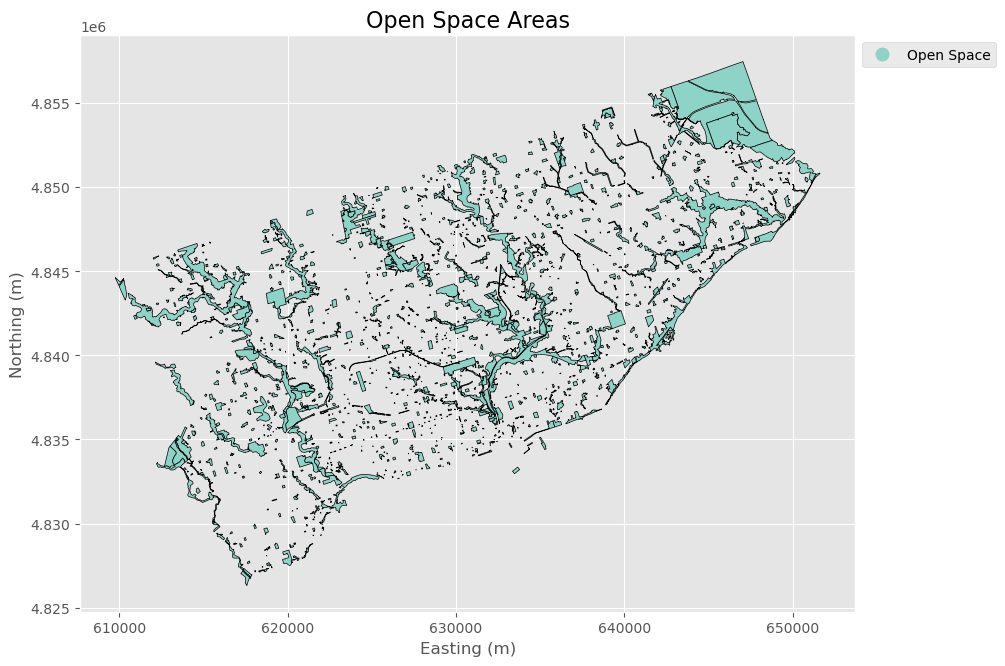

In [6]:
# Let's plot what area is open space
plot_specific_subset(zones_geodata, 'Open Space', 'Zone_type')


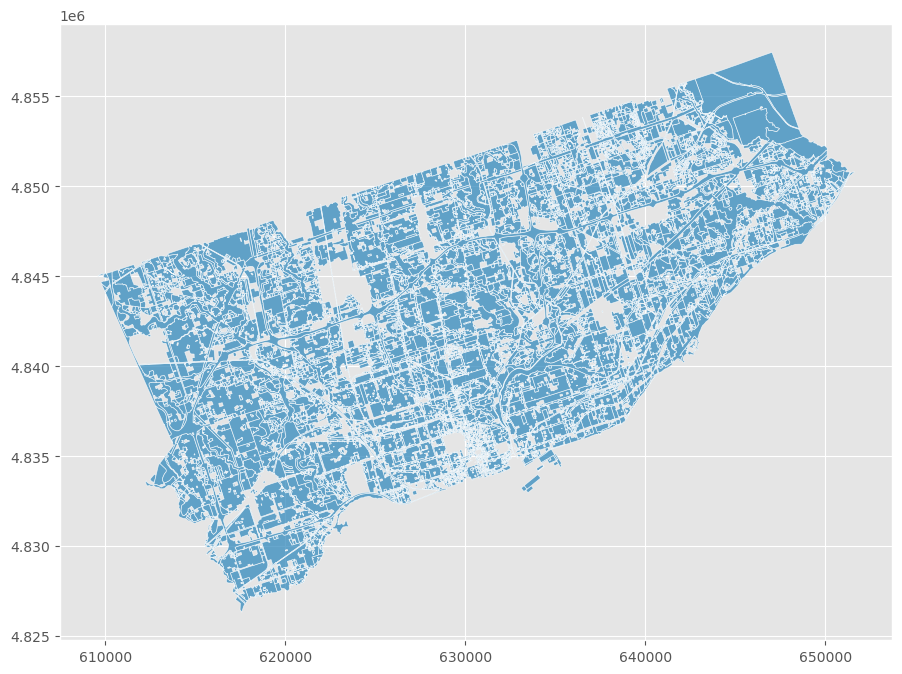

In [7]:
# Plotting all zones... get idea of missingness in data
zones_geodata.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);

### Let's compare this with Greenspace dataset

In [8]:
#Open up greenspace dataset

greenspace = gpd.read_file('Green Spaces - 4326.geojson')

greenspace = keep_relevant_set_index(greenspace, ["_id" ,'AREA_CLASS', 'geometry'])
greenspace.rename(columns={'AREA_CLASS': 'Area_type'}, inplace=True)
greenspace.head()

Area_type                                           geometry
_id                                                                   
1    OTHER_CEMETERY  MULTIPOLYGON (((640102.271 4854414.666, 640113...
2    OTHER_CEMETERY  MULTIPOLYGON (((645572.606 4854015.308, 645584...
3    OTHER_CEMETERY  MULTIPOLYGON (((632908.231 4851886.647, 632908...
4    OTHER_CEMETERY  MULTIPOLYGON (((635279.994 4850925.393, 635266...
5    OTHER_CEMETERY  MULTIPOLYGON (((635435.687 4850637.387, 635434...

In [9]:
greenspace.Area_type.unique() #let's check the type of green spaces

array(['OTHER_CEMETERY', 'OTHER_CITY', 'OTHER_GOLFCOURSE',
       'OTHER_PROVINCIAL_FEDERAL', 'OTHER_HYDRO', 'OTHER_ROAD',
       'OTHER_TRCA', 'OTHER_UNKNOWN', 'Building Grounds', 'Park',
       'Open Green Space', 'Traffic Island', 'Golf Course', 'Cul de Sac',
       'Hydro Field/Utility Corridor', 'Orphaned Space',
       'Civic Centre Square', 'Boulevard', 'Cemetery'], dtype=object)

In [10]:
# Let's simplify the types of "Green space"
greenspace_mapping = {                   
    'OTHER_CEMETERY': 'Cemetery',
    'OTHER_CITY': 'Other',
    'OTHER_GOLFCOURSE': 'Golf course',
    'OTHER_PROVINCIAL_FEDERAL': 'Other',
    'OTHER_HYDRO': 'Utilities and Transportation',
    'OTHER_ROAD': 'Utilities and Transportation', 
    'OTHER_TRCA': 'Greenspace',
    'OTHER_UNKNOWN': 'Other',
    'Building Grounds': 'Other',
    'Park': 'Greenspace',
    'Open Green Space': 'Greenspace',
    'Traffic Island': 'Utilities and Transportation',
    'Golf Course': 'Golf course',
    'Cul de Sac': 'Utilities and Transportation',
    'Hydro Field/Utility Corridor': 'Utilities and Transportation',
    'Orphaned Space': 'Other', 
    'Civic Centre Square': 'Other',
    'Boulevard': 'Utilities and Transportation',
    'Cemetery': 'Cemetery'
}

# Replace the values in 'Zone_type' column with the mapped names
greenspace['Area_type'] = greenspace['Area_type'].replace(greenspace_mapping)

# Display the first few rows to ensure it worked
greenspace.head()

Area_type                                           geometry
_id                                                             
1    Cemetery  MULTIPOLYGON (((640102.271 4854414.666, 640113...
2    Cemetery  MULTIPOLYGON (((645572.606 4854015.308, 645584...
3    Cemetery  MULTIPOLYGON (((632908.231 4851886.647, 632908...
4    Cemetery  MULTIPOLYGON (((635279.994 4850925.393, 635266...
5    Cemetery  MULTIPOLYGON (((635435.687 4850637.387, 635434...

In [11]:
# Check new simplified types
greenspace.Area_type.unique()

array(['Cemetery', 'Other', 'Golf course', 'Utilities and Transportation',
       'Greenspace'], dtype=object)

### Create aggregated greenspace df

In [12]:
aggregated_greenspace = greenspace.groupby('Area_type')['geometry'].apply(lambda x: x.unary_union).reset_index()

# Calculate are in square km, because crs standard area calc will be in m^2
aggregated_greenspace['Area'] = aggregated_greenspace.geometry.area/(1000**2)

# Now 'aggregated_zones' will contain the union of polygons for each 'Zone_type' with the total area
aggregated_greenspace

Area_type  \
0                      Cemetery   
1                   Golf course   
2                    Greenspace   
3                         Other   
4  Utilities and Transportation   

                                            geometry       Area  
0  MULTIPOLYGON (((621149.022 4830435.752, 621167...   4.940155  
1  MULTIPOLYGON (((615377.151 4831863.005, 615401...   9.352223  
2  MULTIPOLYGON (((616481.750 4828955.846, 616493...  84.843899  
3  MULTIPOLYGON (((617286.414 4827385.508, 617244...  12.670473  
4  MULTIPOLYGON (((615820.633 4829249.229, 615879...   9.330665

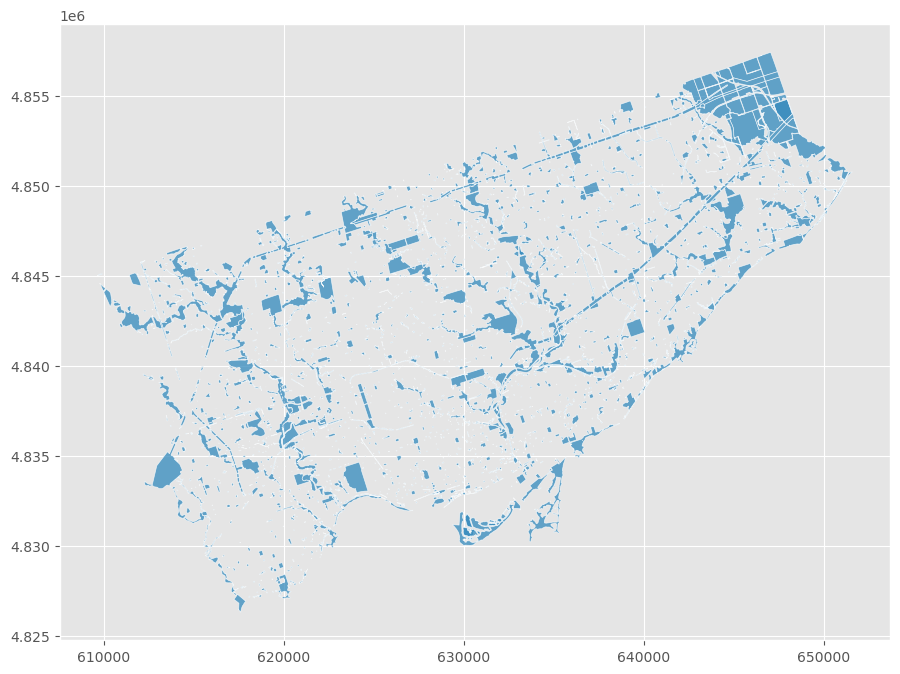

In [13]:
# Let's plot new aggregated df to check its the same 

aggregated_greenspace.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);

### Let's bring in flooding and neighbourhood data

In [14]:
# Open flooding data
#Also, in case not previously noted, this is the floodplain for the 100-year storm
flood_plains = gpd.read_file('Floodline GeoJson Format.geojson')
flood_plains = flood_plains.set_index(flood_plains.columns[0])
flood_plains = flood_plains.to_crs(epsg=26917)
flood_plains.head()

FloodPlain     Watershed    Shape__Are   Shape__Len  \
OBJECTID                                                        
3394      Engineered     Don River      0.940918     3.803569   
3395      Engineered     Don River    869.856689   149.201240   
3396      Engineered     Don River  23187.910400  1321.226703   
3397      Engineered     Don River  10895.613037   522.001575   
3406      Engineered  Humber River      0.544922     5.605709   

                                                   geometry  
OBJECTID                                                     
3394      MULTIPOLYGON (((631822.084 4836644.934, 631822...  
3395      MULTIPOLYGON (((630590.173 4836864.821, 630590...  
3396      MULTIPOLYGON (((630857.614 4836890.388, 630858...  
3397      MULTIPOLYGON (((630721.544 4836901.075, 630722...  
3406      MULTIPOLYGON (((620554.649 4840832.705, 620554...

In [15]:
# Bring in neighbourhood geodata
neighbourhoods_geodata = gpd.read_file('Neighbourhoods - 4326.geojson')
neighbourhoods_geodata = keep_relevant_set_index(neighbourhoods_geodata, ['_id', 'AREA_NAME', 'geometry'])
neighbourhoods_geodata.rename(columns={'AREA_NAME': 'Neighbourhood_name'}, inplace=True)
neighbourhoods_geodata.head()

Neighbourhood_name  \
_id                              
1    South Eglinton-Davisville   
2                North Toronto   
3           Dovercourt Village   
4     Junction-Wallace Emerson   
5           Yonge-Bay Corridor   

                                              geometry  
_id                                                     
1    MULTIPOLYGON (((630028.458 4839577.662, 630038...  
2    MULTIPOLYGON (((629115.632 4840570.870, 629041...  
3    MULTIPOLYGON (((626258.743 4835318.329, 626158...  
4    MULTIPOLYGON (((625873.190 4836146.058, 625898...  
5    MULTIPOLYGON (((630329.072 4833709.787, 630250...

In [16]:
# Lets create "Toronto" geodf that is just all the neighourhoods together

toronto_polygon = neighbourhoods_geodata.geometry.unary_union
toronto = gpd.GeoDataFrame({'geometry': [toronto_polygon]}, crs=neighbourhoods_geodata.crs)
#Calc area in km^2
toronto['Area'] = toronto.geometry.area /(1000**2)
toronto

geometry        Area
0  POLYGON ((619522.645 4827441.297, 619519.365 4...  642.586568

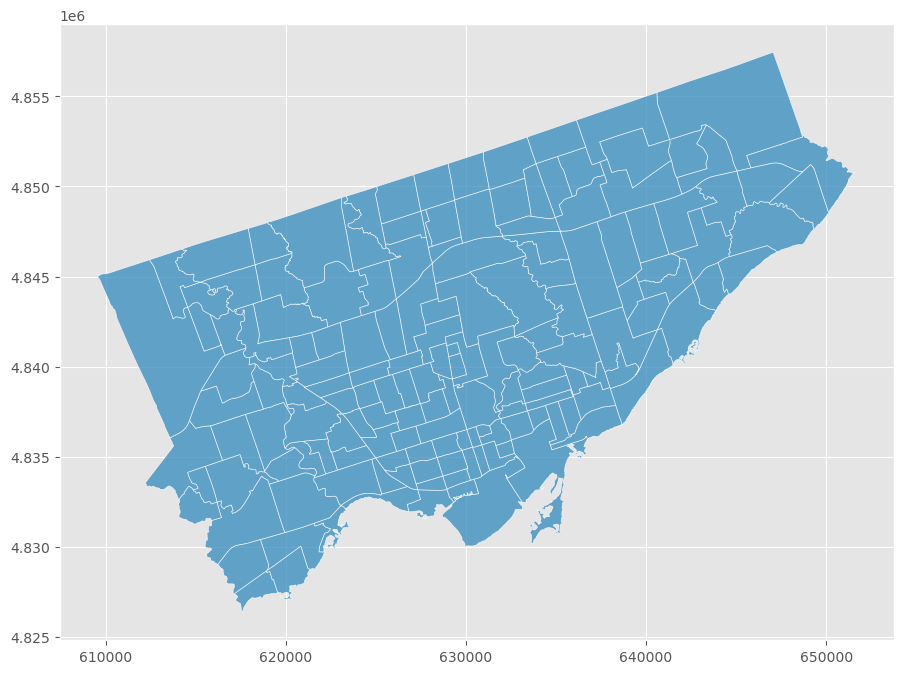

In [17]:
# PLot all neigbourhoods
neighbourhoods_geodata.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);

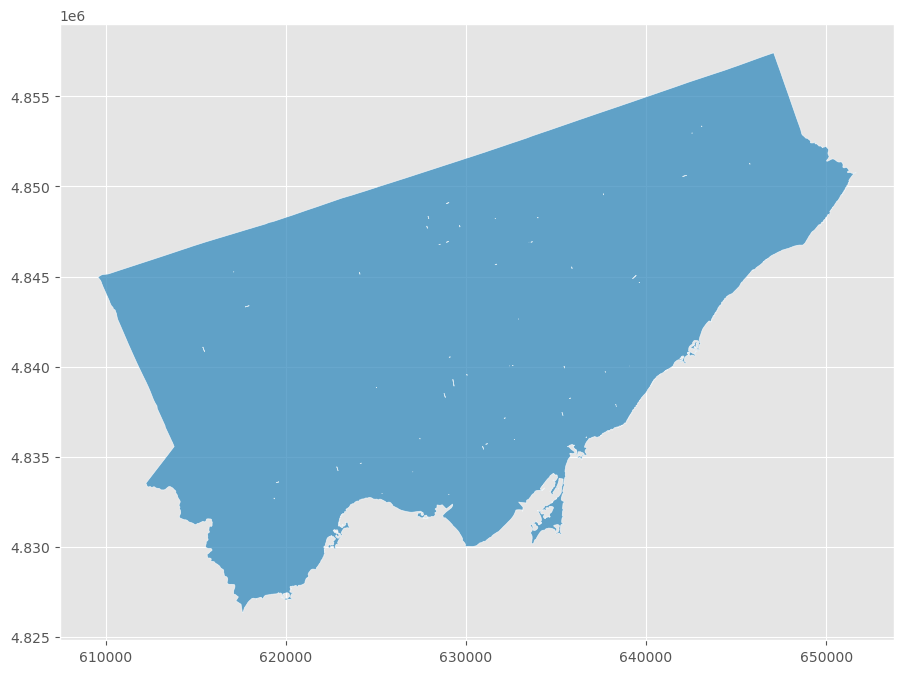

In [18]:
#Plot toronto geodf to compare
toronto.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);

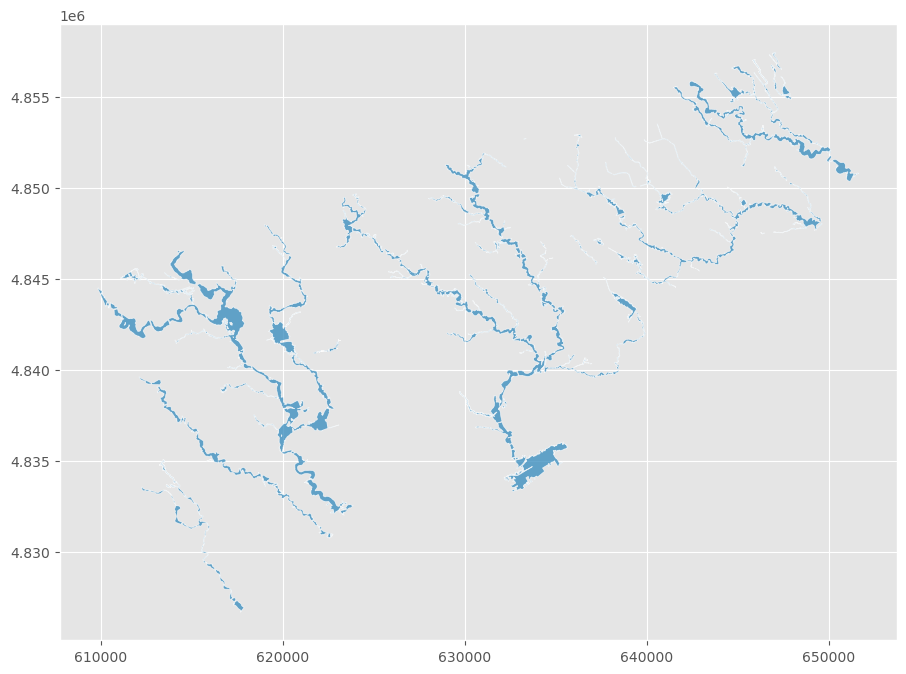

In [19]:
# Use Toronto shape to limit flood plains to toronto

flood_plains = gpd.overlay(flood_plains,toronto , how='intersection')
flood_plains.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);

In [20]:
# Create as single multiploygon for floodplain 

flood_plains_single = flood_plains.geometry.unary_union
flood_plain = gpd.GeoDataFrame({'geometry': [flood_plains_single]}, crs=flood_plains.crs)
# Create area col
flood_plain['Area'] = flood_plain.geometry.area/(1000**2)
flood_plain

geometry       Area
0  MULTIPOLYGON (((617386.706 4827247.947, 617400...  41.986941

### Let's determine percent overlap of flood plains to zones, by zone 

In [21]:
# Open zone_geodata to recall what it looks like
zones_geodata.head()

Zone_type  \
_id                                 
1    Utilities and Transportation   
2                      Open Space   
3                     Residential   
4                      Open Space   
5                     Residential   

                                              geometry  
_id                                                     
1    MULTIPOLYGON (((643976.844 4853137.892, 643984...  
2    MULTIPOLYGON (((620626.556 4840726.078, 620689...  
3    MULTIPOLYGON (((638817.665 4851182.615, 638823...  
4    MULTIPOLYGON (((615151.959 4841962.396, 615149...  
5    MULTIPOLYGON (((639780.906 4852455.190, 639770...

In [22]:
# Group by 'Zone_type' and aggregate the geometries using unary_union (similar to what we did with greenspace)
aggregated_zones = zones_geodata.groupby('Zone_type')['geometry'].apply(lambda x: x.unary_union).reset_index()

# Calculate are in square km, because crs is EPSG 3857, standard area calc will be in m^2
aggregated_zones['Area'] = aggregated_zones.geometry.area/(1000**2)

# Now 'aggregated_zones' will contain the union of polygons for each 'Zone_type' with the total area
aggregated_zones

Zone_type  \
0                    Commercial   
1                    Industrial   
2                 Institutional   
3                    Open Space   
4                   Residential   
5  Utilities and Transportation   

                                            geometry        Area  
0  MULTIPOLYGON (((618990.583 4828066.368, 618990...   21.617256  
1  MULTIPOLYGON (((612550.196 4833612.192, 612543...   56.652189  
2  MULTIPOLYGON (((619949.302 4828228.490, 619947...    3.289453  
3  MULTIPOLYGON (((616610.108 4828600.809, 616622...  105.547687  
4  MULTIPOLYGON (((614483.200 4831594.391, 614484...  302.173822  
5  MULTIPOLYGON (((616646.202 4830760.693, 616594...   31.396594

In [23]:
# Check initial area covered
aggregated_zones['Area'].sum()

520.67700147575

In [24]:
# Let's create unzoned area which is everything that is in the Neighbourhood toronto map, NOT zoned
toronto_geometry = toronto.geometry.iloc[0]

# Get the area of Toronto's geometry in km^2
toronto_area = toronto['Area'].iloc[0] 

# get zoned area geometry
zoned_geometry = toronto_geometry.intersection(aggregated_zones.geometry.unary_union)

# calculate the area of the zoned area in square kilometers (km²)
zoned_area = zoned_geometry.area / (1000**2)

# Calculate the Unzoned area as the difference between Toronto's total area and the zoned areas
unzoned_area = toronto_area - zoned_area

# Create a new row for the Unzoned area
unzoneds = gpd.GeoDataFrame({
    'Zone_type': ['Unzoned'],
    'geometry': [toronto_geometry.difference(aggregated_zones.geometry.unary_union)],
    'Area': [unzoned_area]
}, crs=aggregated_zones.crs)

# Append the Unzoned row to the aggregated_zones GeoDataFrame
aggregated_zones = pd.concat([aggregated_zones, unzoneds], ignore_index=True)
aggregated_zones

Zone_type  \
0                    Commercial   
1                    Industrial   
2                 Institutional   
3                    Open Space   
4                   Residential   
5  Utilities and Transportation   
6                       Unzoned   

                                            geometry        Area  
0  MULTIPOLYGON (((618990.583 4828066.368, 618990...   21.617256  
1  MULTIPOLYGON (((612550.196 4833612.192, 612543...   56.652189  
2  MULTIPOLYGON (((619949.302 4828228.490, 619947...    3.289453  
3  MULTIPOLYGON (((616610.108 4828600.809, 616622...  105.547687  
4  MULTIPOLYGON (((614483.200 4831594.391, 614484...  302.173822  
5  MULTIPOLYGON (((616646.202 4830760.693, 616594...   31.396594  
6  MULTIPOLYGON (((619381.385 4827411.241, 619389...  122.309237

In [25]:
# Total area should be similar to "Toronto" area
aggregated_zones['Area'].sum()

642.9862385777135

In [26]:
# Calculate the area of the intersection (in square units of the CRS)
aggregated_zones['flood_intersection_area'] = aggregated_zones.geometry.intersection(flood_plain.geometry.iloc[0]).area /(1000**2)

# Calculate the total area of the flood plain
flood_plain_area = flood_plain['Area'].iloc[0]

# Calculate the proportion of each zone's intersection with the flood plain
aggregated_zones['Proportion_zone_flooded'] = aggregated_zones['flood_intersection_area'] / aggregated_zones['Area']

aggregated_zones['Proportion of flood that is Zone'] = aggregated_zones['flood_intersection_area'] / flood_plain_area

# Result
aggregated_zones

Zone_type  \
0                    Commercial   
1                    Industrial   
2                 Institutional   
3                    Open Space   
4                   Residential   
5  Utilities and Transportation   
6                       Unzoned   

                                            geometry        Area  \
0  MULTIPOLYGON (((618990.583 4828066.368, 618990...   21.617256   
1  MULTIPOLYGON (((612550.196 4833612.192, 612543...   56.652189   
2  MULTIPOLYGON (((619949.302 4828228.490, 619947...    3.289453   
3  MULTIPOLYGON (((616610.108 4828600.809, 616622...  105.547687   
4  MULTIPOLYGON (((614483.200 4831594.391, 614484...  302.173822   
5  MULTIPOLYGON (((616646.202 4830760.693, 616594...   31.396594   
6  MULTIPOLYGON (((619381.385 4827411.241, 619389...  122.309237   

   flood_intersection_area  Proportion_zone_flooded  \
0                 0.332968                 0.015403   
1                 1.623952                 0.028665   
2                 0.028215                 0.008577   
3                31.227622                 0.295863   
4                 2.923623                 0.009675   
5                 1.490300                 0.047467   
6                 4.361811                 0.035662   

   Proportion of flood that is Zone  
0                          0.007930  
1                          0.038678  
2                          0.000672  
3                          0.743746  
4                          0.069632  
5                          0.035494  
6                          0.103885

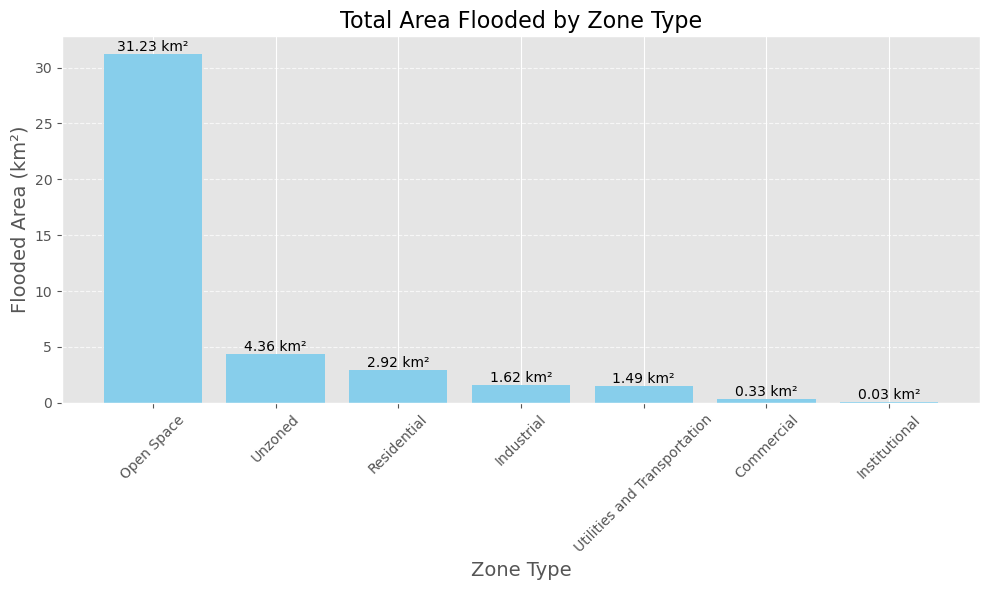

In [27]:
# This is an important df, let's visualize some results

# Sort the data by flooded area (descending order)
aggregated_zones_sorted = aggregated_zones.sort_values(by='flood_intersection_area', ascending=False)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the bar chart with a logarithmic scale
bars = plt.bar(aggregated_zones_sorted['Zone_type'], aggregated_zones_sorted['flood_intersection_area'], color='skyblue')


# Add title and labels
plt.title('Total Area Flooded by Zone Type', fontsize=16)
plt.xlabel('Zone Type', fontsize=14)
plt.ylabel('Flooded Area (km²)', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels above each bar
for i, v in enumerate(aggregated_zones_sorted['flood_intersection_area']):
    plt.text(i, v, f'{v:.2f} km²', ha='center', va='bottom', fontsize=10)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()



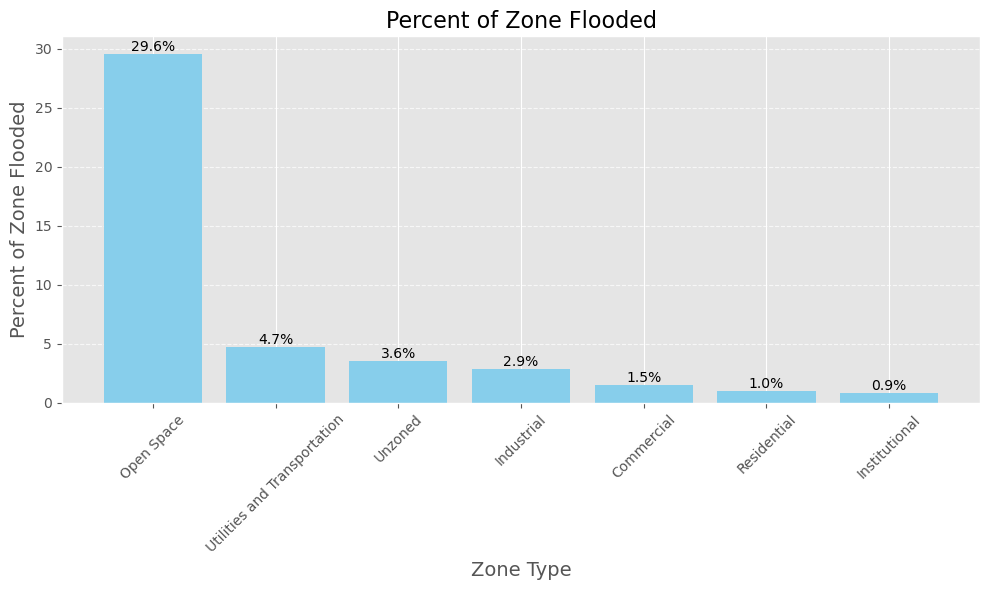

In [28]:
#Secondly, how much are zones being flooded?

# Sort the data by the proportion of zone flooded in descending order for better comparison
aggregated_zones_sorted = aggregated_zones.sort_values(by='Proportion_zone_flooded', ascending=False)


# Create the plot
plt.figure(figsize=(10, 6))

# Plot the bar chart with the proportion converted to percentage and color map
bars = plt.bar(aggregated_zones_sorted['Zone_type'], aggregated_zones_sorted['Proportion_zone_flooded']*100, color='skyblue')

# Add title and labels
plt.title('Percent of Zone Flooded', fontsize=16)
plt.xlabel('Zone Type', fontsize=14)
plt.ylabel('Percent of Zone Flooded', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels above each bar for clarity
for i, v in enumerate(aggregated_zones_sorted['Proportion_zone_flooded']*100):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=10)

# Adjust layout to prevent label clipping
plt.tight_layout()

# Show the plot
plt.show()

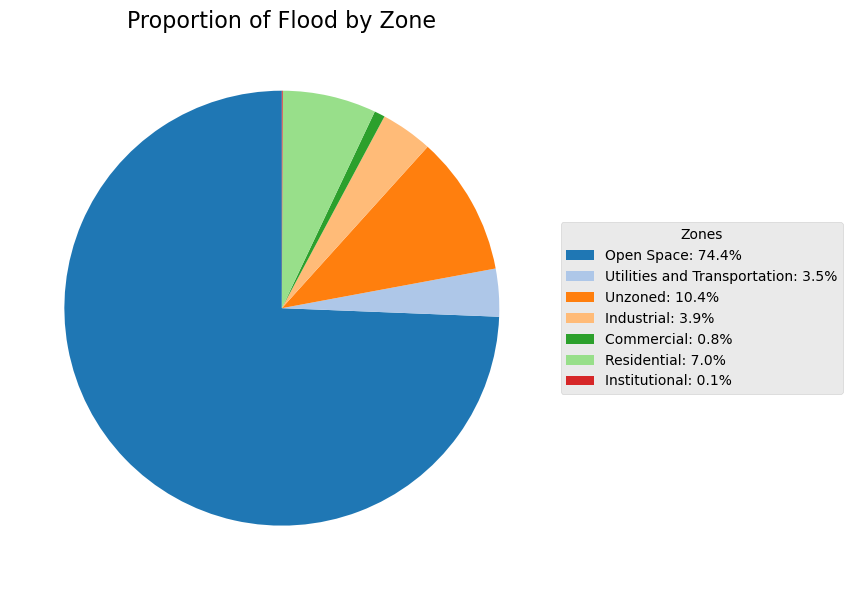

In [29]:
#Lastly, what zones make up the flood?
# Calculate percentages outside of the pie chart
proportions = aggregated_zones_sorted['Proportion of flood that is Zone'] * 100
labels = aggregated_zones_sorted['Zone_type']
colors = plt.cm.tab20.colors[:len(aggregated_zones_sorted)]

plt.figure(figsize=(10, 6))

# Pie chart without displaying the percentage inside the pie chart
plt.pie(proportions, 
        startangle=90,  # Start the pie chart at a specific angle for better layout
        colors=colors,  # Use the tab20 color palette
        labeldistance=1.1)  # Move the labels further out to avoid overlap

# Add title
plt.title('Proportion of Flood by Zone', fontsize=16)

# Add a legend outside the pie chart
# The legend will include both zone names and their corresponding percentages
legend_labels = [f'{label}: {proportion:.1f}%' for label, proportion in zip(labels, proportions)]
plt.legend(legend_labels, title="Zones", loc="center left", bbox_to_anchor=(1, 0.5))

# Show the pie chart with the legend
plt.tight_layout()
plt.show()

In [30]:
# Check that proportions of flood sum to 1
aggregated_zones['Proportion of flood that is Zone'].sum()

1.000036945101994

In [31]:
# Write to GeoJSON to use for future use/sharing
aggregated_zones.to_file("Zones and Flooding.geojson", driver="GeoJSON")

# Print confirmation comment
print("DataFrame has been written to 'Zones and Flooding.geojson'")

DataFrame has been written to 'Zones and Flooding.geojson'


### Let's determine percent overlap of flood plains to "Green space", by type (just to compare/validate data) 

In [32]:
# Step 2: Calculate the area of the intersection (in square units of the CRS)
aggregated_greenspace['flood_intersection_area'] = aggregated_greenspace.geometry.intersection(flood_plain.geometry.iloc[0]).area /(1000**2)


# Step 4: Calculate the proportion of each zone's intersection with the flood plain
aggregated_greenspace['Proportion_zone_flooded'] = aggregated_greenspace['flood_intersection_area'] / aggregated_greenspace['Area']

aggregated_greenspace['Proportion of flood that is Zone'] = aggregated_greenspace['flood_intersection_area'] / flood_plain_area

# Result
aggregated_greenspace

Area_type  \
0                      Cemetery   
1                   Golf course   
2                    Greenspace   
3                         Other   
4  Utilities and Transportation   

                                            geometry       Area  \
0  MULTIPOLYGON (((621149.022 4830435.752, 621167...   4.940155   
1  MULTIPOLYGON (((615377.151 4831863.005, 615401...   9.352223   
2  MULTIPOLYGON (((616481.750 4828955.846, 616493...  84.843899   
3  MULTIPOLYGON (((617286.414 4827385.508, 617244...  12.670473   
4  MULTIPOLYGON (((615820.633 4829249.229, 615879...   9.330665   

   flood_intersection_area  Proportion_zone_flooded  \
0                 0.121006                 0.024494   
1                 3.890091                 0.415954   
2                23.463766                 0.276552   
3                 2.098237                 0.165601   
4                 0.694149                 0.074394   

   Proportion of flood that is Zone  
0                          0.002882  
1                          0.092650  
2                          0.558835  
3                          0.049974  
4                          0.016532

In [33]:
# Check how much is NOT flooded by greenspace...
print(str(round((1-aggregated_greenspace['Proportion of flood that is Zone'].sum())*100,2)
         ) + "% of flooded area is not considered by green space dataset")

27.91% of flooded area is not considered by green space dataset


In [34]:
# Is approximately the same area as zone type "Open Space" flooded (74%)
round((aggregated_greenspace['Proportion of flood that is Zone'].sum())*100,2)

72.09

### Let's do the same exercise for neighbourhoods to see what neighbourhoods are the most flooded...

In [35]:
# Make the index the first col
neighbourhoods_copy = neighbourhoods_geodata #there's a reason I did this but it is obselete but I don't want to rewrite all the code 
                                             #I should not have made a copy but it's too late it's what I call the variable 

# Get area in km^2
neighbourhoods_copy['Area'] = neighbourhoods_copy.geometry.area / (1000**2)

neighbourhoods_copy 

Neighbourhood_name  \
_id                              
1    South Eglinton-Davisville   
2                North Toronto   
3           Dovercourt Village   
4     Junction-Wallace Emerson   
5           Yonge-Bay Corridor   
..                         ...   
154     West Humber-Clairville   
155                Black Creek   
156       Pelmo Park-Humberlea   
157                 Humbermede   
158              Humber Summit   

                                              geometry       Area  
_id                                                                
1    MULTIPOLYGON (((630028.458 4839577.662, 630038...   0.944309  
2    MULTIPOLYGON (((629115.632 4840570.870, 629041...   0.402031  
3    MULTIPOLYGON (((626258.743 4835318.329, 626158...   1.503002  
4    MULTIPOLYGON (((625873.190 4836146.058, 625898...   2.222867  
5    MULTIPOLYGON (((630329.072 4833709.787, 630250...   1.118725  
..                                                 ...        ...  
154  MULTIPOLYGON (((613519.934 4843296.232, 613600...  30.145339  
155  MULTIPOLYGON (((619176.509 4847836.650, 619187...   3.453855  
156  MULTIPOLYGON (((618198.454 4843492.609, 618452...   4.276214  
157  MULTIPOLYGON (((618512.447 4844520.713, 618594...   4.421686  
158  MULTIPOLYGON (((617993.996 4847245.152, 618144...   7.966914  

[158 rows x 3 columns]

In [36]:
# Calculate the area of the intersection with flooding
neighbourhoods_copy['flood_intersection_area'] = neighbourhoods_copy.geometry.intersection(flood_plain.geometry.iloc[0]).area /(1000**2)

# Get the total area of the flood plain
flood_plain_area = flood_plain['Area'].iloc[0]

# Calculate the proportion of each zone's intersection with the flood plain
neighbourhoods_copy['Proportion Neighbourhood flooded'] = neighbourhoods_copy['flood_intersection_area'] / neighbourhoods_copy['Area']

neighbourhoods_copy['Proportion of flood that is Neighbourhood'] = neighbourhoods_copy['flood_intersection_area'] / flood_plain_area

#Sort by most flooded neighbourhood
neighbourhoods_copy = neighbourhoods_copy.sort_values(by='Proportion Neighbourhood flooded', ascending=False)  # Use ascending=False for descending order
neighbourhoods_copy

Neighbourhood_name  \
_id                                 
150              Elms-Old Rexdale   
77              Rockcliffe-Smythe   
152  Thistletown-Beaumond Heights   
86                South Riverdale   
74             Lambton Baby Point   
..                            ...   
65         Corso Italia-Davenport   
64                       Wychwood   
63                          Annex   
62                      Casa Loma   
80                     University   

                                              geometry       Area  \
_id                                                                 
150  MULTIPOLYGON (((617036.099 4843084.408, 617072...   2.931077   
77   MULTIPOLYGON (((622906.715 4837589.820, 622945...   5.070942   
152  MULTIPOLYGON (((615765.096 4844414.710, 615759...   3.339552   
86   MULTIPOLYGON (((634777.162 4835393.561, 634781...  11.030185   
74   MULTIPOLYGON (((620997.191 4835850.694, 620999...   1.782160   
..                                                 ...        ...   
65   MULTIPOLYGON (((625452.962 4837670.198, 625547...   1.889356   
64   MULTIPOLYGON (((627500.398 4837848.962, 627527...   1.682042   
63   MULTIPOLYGON (((627613.208 4835753.867, 627517...   2.790299   
62   MULTIPOLYGON (((628942.392 4837967.303, 628945...   1.922412   
80   MULTIPOLYGON (((629043.882 4835131.447, 629033...   1.405204   

     flood_intersection_area  Proportion Neighbourhood flooded  \
_id                                                              
150                 1.208703                          0.412375   
77                  1.660268                          0.327408   
152                 0.889458                          0.266341   
86                  2.500970                          0.226739   
74                  0.351825                          0.197415   
..                       ...                               ...   
65                  0.000000                          0.000000   
64                  0.000000                          0.000000   
63                  0.000000                          0.000000   
62                  0.000000                          0.000000   
80                  0.000000                          0.000000   

     Proportion of flood that is Neighbourhood  
_id                                             
150                                   0.028788  
77                                    0.039542  
152                                   0.021184  
86                                    0.059565  
74                                    0.008379  
..                                         ...  
65                                    0.000000  
64                                    0.000000  
63                                    0.000000  
62                                    0.000000  
80                                    0.000000  

[158 rows x 6 columns]

In [37]:
#Check flood area is fully accounted for, proportions should sum to 1
neighbourhoods_copy['Proportion of flood that is Neighbourhood'].sum()

1.000000008498181

In [38]:
# Write to GeoJSON to use for future...
neighbourhoods_copy.to_file("Neighbourhoods and Flooding.geojson", driver="GeoJSON")

# Print confirmation comment
print("DataFrame has been written to 'Neighbourhoods and Flooding.geojson'")

DataFrame has been written to 'Neighbourhoods and Flooding.geojson'


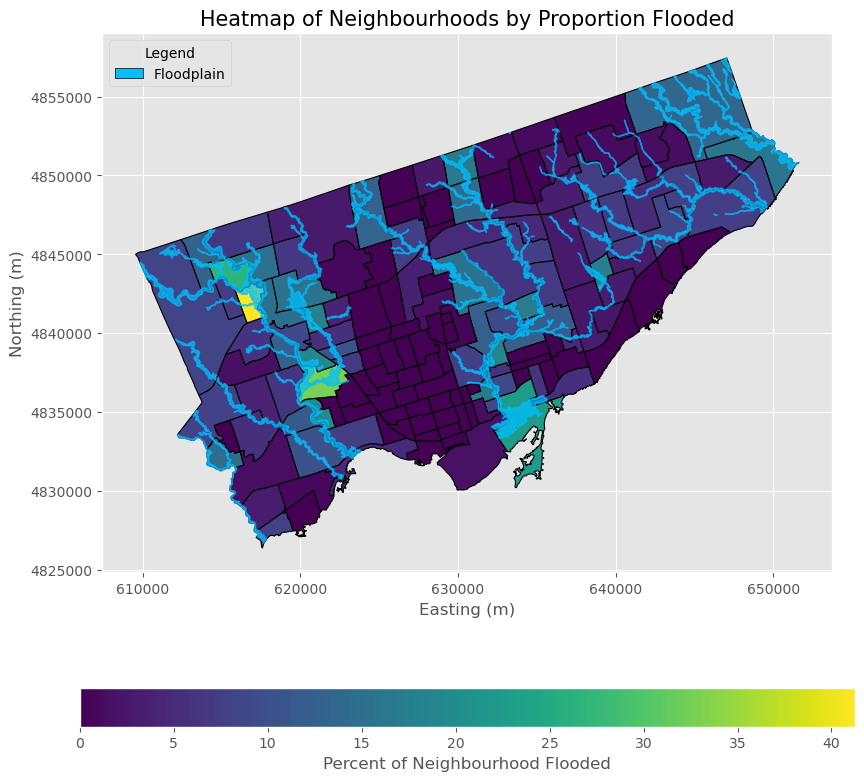

In [39]:
# Let's plot which neighbourhoods are most flooded by proportion (percent)
neighbourhoods_copy['Percent Neighbourhood Flooded'] = neighbourhoods_copy['Proportion Neighbourhood flooded'] * 100

fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed
neighbourhoods_copy.plot(column='Percent Neighbourhood Flooded', 
                         cmap='viridis',  
                         linewidth=0.8, 
                         ax=ax, 
                         edgecolor='k',  # Adds a black border around each neighborhood
                         legend=True,  # Adds a legend for color mapping
                         legend_kwds={'label': "Percent of Neighbourhood Flooded",
                                      'orientation': "horizontal"})

#Overlay the flood plain
flood_plain.plot(ax=ax, color=(0/255, 191/255, 255/255), edgecolor=(0/255, 191/255, 255/255), linewidth=1, alpha=0.7) 

# Add title and labels
ax.set_title("Heatmap of Neighbourhoods by Proportion Flooded", fontsize=15)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
# Ensure axis ticks are not in scientific notation
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)  # Disable scientific notation

legend_elements = [
    Patch(facecolor=(0/255, 191/255, 255/255), edgecolor='k', label='Floodplain')
]
ax.legend(handles=legend_elements, loc='upper left', title="Legend")

ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Show plot
plt.show()

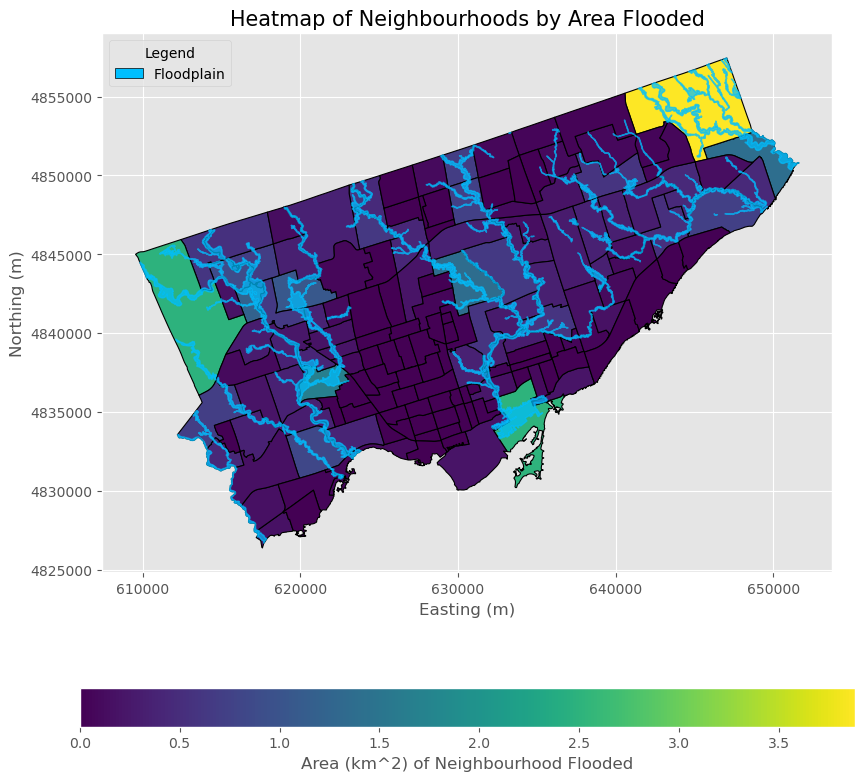

In [40]:
# Let's plot which neighbourhoods are most flooded by absolute area

fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed
neighbourhoods_copy.plot(column='flood_intersection_area', 
                         cmap='viridis',  
                         linewidth=0.8, 
                         ax=ax, 
                         edgecolor='k',  # Adds a black border around each neighborhood
                         legend=True,  # Adds a legend for color mapping
                         legend_kwds={'label': "Area (km^2) of Neighbourhood Flooded",
                                      'orientation': "horizontal"})

#Overlay the flood plain
flood_plain.plot(ax=ax, color=(0/255, 191/255, 255/255), edgecolor=(0/255, 191/255, 255/255), linewidth=1, alpha=0.7)  # Customize appearance

# Add title and labels
ax.set_title("Heatmap of Neighbourhoods by Area Flooded", fontsize=15)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
# Ensure axis ticks are not in scientific notation
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)  # Disable scientific notation

ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

legend_elements = [
    Patch(facecolor=(0/255, 191/255, 255/255), edgecolor='k', label='Floodplain')
]
ax.legend(handles=legend_elements, loc='upper left', title="Legend")

# Show plot
plt.show()

### Now we know which neighbourhoods are flooded, but doesn't most flooding happen in open space anyways?
Let's determine which neighbourhoods have the most non-open space flooding using the greenspace dataset because it is more granular in differentiating the type of open space

In [41]:
# recall what df looks like
neighbourhoods_copy

Neighbourhood_name  \
_id                                 
150              Elms-Old Rexdale   
77              Rockcliffe-Smythe   
152  Thistletown-Beaumond Heights   
86                South Riverdale   
74             Lambton Baby Point   
..                            ...   
65         Corso Italia-Davenport   
64                       Wychwood   
63                          Annex   
62                      Casa Loma   
80                     University   

                                              geometry       Area  \
_id                                                                 
150  MULTIPOLYGON (((617036.099 4843084.408, 617072...   2.931077   
77   MULTIPOLYGON (((622906.715 4837589.820, 622945...   5.070942   
152  MULTIPOLYGON (((615765.096 4844414.710, 615759...   3.339552   
86   MULTIPOLYGON (((634777.162 4835393.561, 634781...  11.030185   
74   MULTIPOLYGON (((620997.191 4835850.694, 620999...   1.782160   
..                                                 ...        ...   
65   MULTIPOLYGON (((625452.962 4837670.198, 625547...   1.889356   
64   MULTIPOLYGON (((627500.398 4837848.962, 627527...   1.682042   
63   MULTIPOLYGON (((627613.208 4835753.867, 627517...   2.790299   
62   MULTIPOLYGON (((628942.392 4837967.303, 628945...   1.922412   
80   MULTIPOLYGON (((629043.882 4835131.447, 629033...   1.405204   

     flood_intersection_area  Proportion Neighbourhood flooded  \
_id                                                              
150                 1.208703                          0.412375   
77                  1.660268                          0.327408   
152                 0.889458                          0.266341   
86                  2.500970                          0.226739   
74                  0.351825                          0.197415   
..                       ...                               ...   
65                  0.000000                          0.000000   
64                  0.000000                          0.000000   
63                  0.000000                          0.000000   
62                  0.000000                          0.000000   
80                  0.000000                          0.000000   

     Proportion of flood that is Neighbourhood  Percent Neighbourhood Flooded  
_id                                                                            
150                                   0.028788                      41.237492  
77                                    0.039542                      32.740808  
152                                   0.021184                      26.634067  
86                                    0.059565                      22.673867  
74                                    0.008379                      19.741502  
..                                         ...                            ...  
65                                    0.000000                       0.000000  
64                                    0.000000                       0.000000  
63                                    0.000000                       0.000000  
62                                    0.000000                       0.000000  
80                                    0.000000                       0.000000  

[158 rows x 7 columns]

In [42]:
aggregated_greenspace

Area_type  \
0                      Cemetery   
1                   Golf course   
2                    Greenspace   
3                         Other   
4  Utilities and Transportation   

                                            geometry       Area  \
0  MULTIPOLYGON (((621149.022 4830435.752, 621167...   4.940155   
1  MULTIPOLYGON (((615377.151 4831863.005, 615401...   9.352223   
2  MULTIPOLYGON (((616481.750 4828955.846, 616493...  84.843899   
3  MULTIPOLYGON (((617286.414 4827385.508, 617244...  12.670473   
4  MULTIPOLYGON (((615820.633 4829249.229, 615879...   9.330665   

   flood_intersection_area  Proportion_zone_flooded  \
0                 0.121006                 0.024494   
1                 3.890091                 0.415954   
2                23.463766                 0.276552   
3                 2.098237                 0.165601   
4                 0.694149                 0.074394   

   Proportion of flood that is Zone  
0                          0.002882  
1                          0.092650  
2                          0.558835  
3                          0.049974  
4                          0.016532

In [43]:
# Check total area
aggregated_greenspace['Area'].sum()

121.13741511971733

#### Let's further simplify the greenspace df by true greenspace, or not

In [44]:
aggregated_greenspace["Area_type"] = aggregated_greenspace["Area_type"].apply(lambda x: "Greenspace" if x == "Greenspace" else "Other")

# Dissolve by the Category column and aggregate the numeric columns
aggregated_greenspace = aggregated_greenspace.dissolve(by="Area_type", aggfunc="sum")

# Reset the index to make it a standard GeoDataFrame
aggregated_greenspace = aggregated_greenspace.reset_index()

aggregated_greenspace

Area_type                                           geometry       Area  \
0  Greenspace  MULTIPOLYGON (((616558.587 4828859.160, 616563...  84.843899   
1       Other  MULTIPOLYGON (((616174.438 4829343.829, 616187...  36.293516   

   flood_intersection_area  Proportion_zone_flooded  \
0                23.463766                 0.276552   
1                 6.803484                 0.680443   

   Proportion of flood that is Zone  
0                          0.558835  
1                          0.162038

In [45]:
# Check total area, make sure I did it right
aggregated_greenspace['Area'].sum()

121.13741511971733

#### We need to break up each neighbourhood into 4 subareas: flooded greenspace, flooded other, not flooded greenspace, not flooded other

In [46]:
# Calculate greenspace area
neighbourhoods_copy['Greenspace_area'] = neighbourhoods_copy.geometry.intersection(aggregated_greenspace.geometry.iloc[0]).area /(1000**2)

#Proportion of neighbourhood that is greenspace
neighbourhoods_copy['Proportion Greenspace'] = neighbourhoods_copy['Greenspace_area'] / neighbourhoods_copy['Area']

# Calculate area of greenspace flooded
neighbourhoods_copy['Greenspace_flooded_area'] = neighbourhoods_copy.geometry.intersection(aggregated_greenspace.geometry.iloc[0]).intersection(flood_plain.geometry.iloc[0]).area /(1000**2)

# Area of greenspace not flooded
neighbourhoods_copy['Greenspace_not_flooded_area'] = neighbourhoods_copy['Greenspace_area'] - neighbourhoods_copy['Greenspace_flooded_area']

# Area of not greenspace flooded
neighbourhoods_copy['Not_greenspace_flooded_area'] = neighbourhoods_copy['flood_intersection_area'] - neighbourhoods_copy['Greenspace_flooded_area']

# Proportion of not greenspace flooded to total neighbourhood area
neighbourhoods_copy['Proportion non-greenspace flooded to Area'] = neighbourhoods_copy['Not_greenspace_flooded_area']/neighbourhoods_copy['Area']

neighbourhoods_copy

Neighbourhood_name  \
_id                                 
150              Elms-Old Rexdale   
77              Rockcliffe-Smythe   
152  Thistletown-Beaumond Heights   
86                South Riverdale   
74             Lambton Baby Point   
..                            ...   
65         Corso Italia-Davenport   
64                       Wychwood   
63                          Annex   
62                      Casa Loma   
80                     University   

                                              geometry       Area  \
_id                                                                 
150  MULTIPOLYGON (((617036.099 4843084.408, 617072...   2.931077   
77   MULTIPOLYGON (((622906.715 4837589.820, 622945...   5.070942   
152  MULTIPOLYGON (((615765.096 4844414.710, 615759...   3.339552   
86   MULTIPOLYGON (((634777.162 4835393.561, 634781...  11.030185   
74   MULTIPOLYGON (((620997.191 4835850.694, 620999...   1.782160   
..                                                 ...        ...   
65   MULTIPOLYGON (((625452.962 4837670.198, 625547...   1.889356   
64   MULTIPOLYGON (((627500.398 4837848.962, 627527...   1.682042   
63   MULTIPOLYGON (((627613.208 4835753.867, 627517...   2.790299   
62   MULTIPOLYGON (((628942.392 4837967.303, 628945...   1.922412   
80   MULTIPOLYGON (((629043.882 4835131.447, 629033...   1.405204   

     flood_intersection_area  Proportion Neighbourhood flooded  \
_id                                                              
150                 1.208703                          0.412375   
77                  1.660268                          0.327408   
152                 0.889458                          0.266341   
86                  2.500970                          0.226739   
74                  0.351825                          0.197415   
..                       ...                               ...   
65                  0.000000                          0.000000   
64                  0.000000                          0.000000   
63                  0.000000                          0.000000   
62                  0.000000                          0.000000   
80                  0.000000                          0.000000   

     Proportion of flood that is Neighbourhood  Percent Neighbourhood Flooded  \
_id                                                                             
150                                   0.028788                      41.237492   
77                                    0.039542                      32.740808   
152                                   0.021184                      26.634067   
86                                    0.059565                      22.673867   
74                                    0.008379                      19.741502   
..                                         ...                            ...   
65                                    0.000000                       0.000000   
64                                    0.000000                       0.000000   
63                                    0.000000                       0.000000   
62                                    0.000000                       0.000000   
80                                    0.000000                       0.000000   

     Greenspace_area  Proportion Greenspace  Greenspace_flooded_area  \
_id                                                                    
150         0.737576               0.251640                 0.551077   
77          0.593422               0.117024                 0.341783   
152         0.957007               0.286568                 0.743371   
86          2.787658               0.252730                 0.040405   
74          0.476740               0.267507                 0.309836   
..               ...                    ...                      ...   
65          0.127460               0.067462                 0.000000   
64          0.066152               0.039329                 0.000000   
63

In [47]:
# Let's check total greenspace sum properly...
neighbourhoods_copy['Greenspace_flooded_area'].sum() + neighbourhoods_copy['Greenspace_not_flooded_area'].sum()

# should be about 84 km^2 of total greenspace

84.51684697958714

In [48]:
# Calculate sum of flooded area
neighbourhoods_copy['Greenspace_flooded_area'].sum() + neighbourhoods_copy['Not_greenspace_flooded_area'].sum()

# should be about 41.98 km^2 of total flooded area

41.98694114894413

#### Let's visually check which neighbourhoods are most flooded, by NON greenspace area proportion

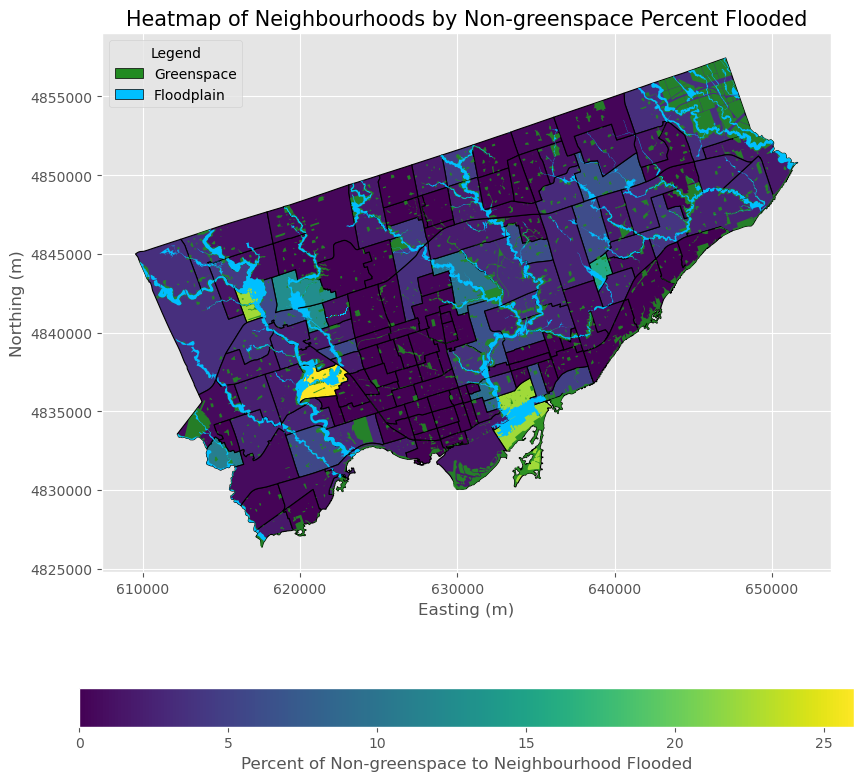

In [49]:

fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed
neighbourhoods_copy['Percent non-greenspace flooded to Area'] = neighbourhoods_copy['Proportion non-greenspace flooded to Area'] * 100

neighbourhoods_copy.plot(column='Percent non-greenspace flooded to Area', 
                         cmap='viridis',  
                         linewidth=0.8, 
                         ax=ax, 
                         edgecolor='k',  # Adds a black border around each neighborhood
                         legend=True,  # Adds a legend for color mapping
                         legend_kwds={'label': "Percent of Non-greenspace to Neighbourhood Flooded",
                                      'orientation': "horizontal"})
#Overlay the greenspace
aggregated_greenspace.iloc[[0]].plot(ax=ax, color='forestgreen', linewidth=1, alpha=0.9)  

#Overlay the flood plain
flood_plain.plot(ax=ax, color=(0/255, 191/255, 255/255), linewidth=1, alpha=1)  

legend_elements = [
    Patch(facecolor='forestgreen', edgecolor='k', label='Greenspace'),
    Patch(facecolor=(0/255, 191/255, 255/255), edgecolor='k', label='Floodplain')
]
ax.legend(handles=legend_elements, loc='upper left', title="Legend")

# Add title and labels
ax.set_title("Heatmap of Neighbourhoods by Non-greenspace Percent Flooded", fontsize=15)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
# Ensure axis ticks are not in scientific notation
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)  # Disable scientific notation

ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Show plot
plt.show()

#### Same except by absolute total non-greespace flooded area

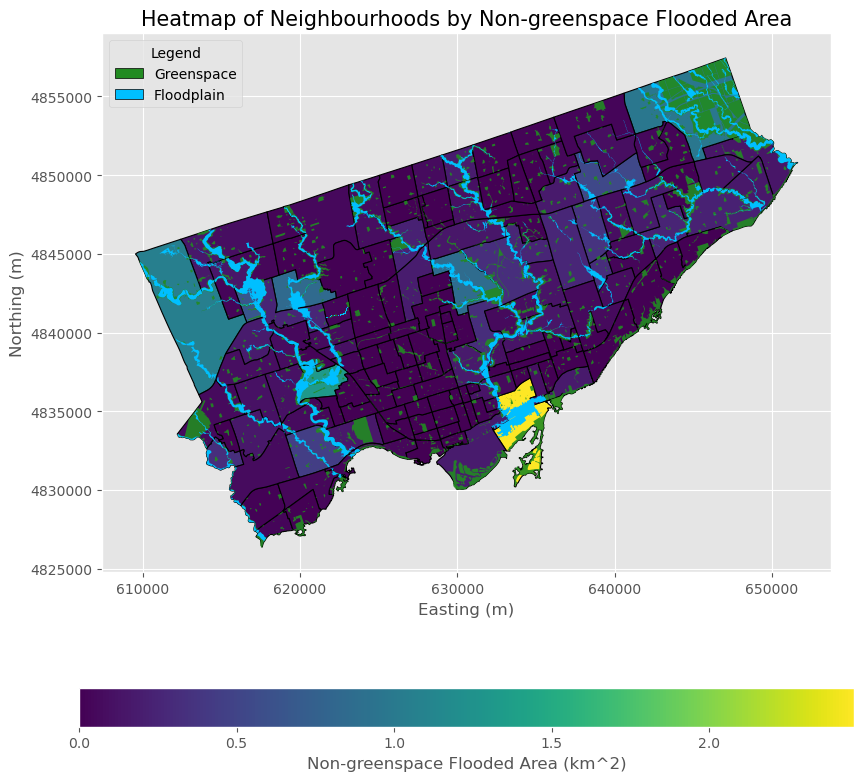

In [50]:
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed
neighbourhoods_copy.plot(column='Not_greenspace_flooded_area', 
                         cmap='viridis',  
                         linewidth=0.8, 
                         ax=ax, 
                         edgecolor='k',  # Adds a black border around each neighborhood
                         legend=True,  # Adds a legend for color mapping
                         legend_kwds={'label': "Non-greenspace Flooded Area (km^2)",
                                      'orientation': "horizontal"})
#Overlay the greenspace
aggregated_greenspace.iloc[[0]].plot(ax=ax, color='forestgreen', linewidth=1, alpha=0.9)  

#Overlay the flood plain
flood_plain.plot(ax=ax, color=(0/255, 191/255, 255/255), linewidth=1, alpha=1)  

legend_elements = [
    Patch(facecolor='forestgreen', edgecolor='k', label='Greenspace'),
    Patch(facecolor=(0/255, 191/255, 255/255), edgecolor='k', label='Floodplain')
]
ax.legend(handles=legend_elements, loc='upper left', title="Legend")

# Add title and labels
ax.set_title("Heatmap of Neighbourhoods by Non-greenspace Flooded Area", fontsize=15)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
# Ensure axis ticks are not in scientific notation
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)  # Disable scientific notation

ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Show plot
plt.show()

## Let's instead use Zoning dataset to consider which Neighbourhoods are most flooded by each respective zone

In [51]:
# Recall zoning datset
aggregated_zones

Zone_type  \
0                    Commercial   
1                    Industrial   
2                 Institutional   
3                    Open Space   
4                   Residential   
5  Utilities and Transportation   
6                       Unzoned   

                                            geometry        Area  \
0  MULTIPOLYGON (((618990.583 4828066.368, 618990...   21.617256   
1  MULTIPOLYGON (((612550.196 4833612.192, 612543...   56.652189   
2  MULTIPOLYGON (((619949.302 4828228.490, 619947...    3.289453   
3  MULTIPOLYGON (((616610.108 4828600.809, 616622...  105.547687   
4  MULTIPOLYGON (((614483.200 4831594.391, 614484...  302.173822   
5  MULTIPOLYGON (((616646.202 4830760.693, 616594...   31.396594   
6  MULTIPOLYGON (((619381.385 4827411.241, 619389...  122.309237   

   flood_intersection_area  Proportion_zone_flooded  \
0                 0.332968                 0.015403   
1                 1.623952                 0.028665   
2                 0.028215                 0.008577   
3                31.227622                 0.295863   
4                 2.923623                 0.009675   
5                 1.490300                 0.047467   
6                 4.361811                 0.035662   

   Proportion of flood that is Zone  
0                          0.007930  
1                          0.038678  
2                          0.000672  
3                          0.743746  
4                          0.069632  
5                          0.035494  
6                          0.103885

In [52]:
aggregated_zones['Zone_type'].unique()

array(['Commercial', 'Industrial', 'Institutional', 'Open Space',
       'Residential', 'Utilities and Transportation', 'Unzoned'],
      dtype=object)

In [53]:
#We need to determine similar columns for each zone

#Let's get area of zone type flooded, zone type not flooded, and proportion of zone type flooded to zone type 
for index, row in aggregated_zones.iterrows():
    
    # Calculate the intersection area of each neighbourhood with the current zone
    neighbourhoods_copy[str(row['Zone_type'] + " area")] = (
        neighbourhoods_copy.geometry.intersection(row.geometry).area / (1000**2)  # Converts to km^2
    )
    
    # Calculate area of zone flooded
    neighbourhoods_copy[str(row['Zone_type'] + " area flooded")] = neighbourhoods_copy.geometry.intersection(
        row.geometry).intersection(
        flood_plain.geometry.iloc[0]).area /(1000**2)

    # Area of zone not flooded
    neighbourhoods_copy[str(row['Zone_type'] + " area not flooded")] = neighbourhoods_copy[str(row['Zone_type'] + " area")] - neighbourhoods_copy[str(row['Zone_type'] + " area flooded")]

    # Proportion of zone flooded to total zone area
    neighbourhoods_copy[str(row['Zone_type'] + " proportion flooded in neighbourhood")] = neighbourhoods_copy[str(row['Zone_type'] + " area flooded")]/neighbourhoods_copy[str(row['Zone_type'] + " area")]

neighbourhoods_copy

Neighbourhood_name  \
_id                                 
150              Elms-Old Rexdale   
77              Rockcliffe-Smythe   
152  Thistletown-Beaumond Heights   
86                South Riverdale   
74             Lambton Baby Point   
..                            ...   
65         Corso Italia-Davenport   
64                       Wychwood   
63                          Annex   
62                      Casa Loma   
80                     University   

                                              geometry       Area  \
_id                                                                 
150  MULTIPOLYGON (((617036.099 4843084.408, 617072...   2.931077   
77   MULTIPOLYGON (((622906.715 4837589.820, 622945...   5.070942   
152  MULTIPOLYGON (((615765.096 4844414.710, 615759...   3.339552   
86   MULTIPOLYGON (((634777.162 4835393.561, 634781...  11.030185   
74   MULTIPOLYGON (((620997.191 4835850.694, 620999...   1.782160   
..                                                 ...        ...   
65   MULTIPOLYGON (((625452.962 4837670.198, 625547...   1.889356   
64   MULTIPOLYGON (((627500.398 4837848.962, 627527...   1.682042   
63   MULTIPOLYGON (((627613.208 4835753.867, 627517...   2.790299   
62   MULTIPOLYGON (((628942.392 4837967.303, 628945...   1.922412   
80   MULTIPOLYGON (((629043.882 4835131.447, 629033...   1.405204   

     flood_intersection_area  Proportion Neighbourhood flooded  \
_id                                                              
150                 1.208703                          0.412375   
77                  1.660268                          0.327408   
152                 0.889458                          0.266341   
86                  2.500970                          0.226739   
74                  0.351825                          0.197415   
..                       ...                               ...   
65                  0.000000                          0.000000   
64                  0.000000                          0.000000   
63                  0.000000                          0.000000   
62                  0.000000                          0.000000   
80                  0.000000                          0.000000   

     Proportion of flood that is Neighbourhood  Percent Neighbourhood Flooded  \
_id                                                                             
150                                   0.028788                      41.237492   
77                                    0.039542                      32.740808   
152                                   0.021184                      26.634067   
86                                    0.059565                      22.673867   
74                                    0.008379                      19.741502   
..                                         ...                            ...   
65                                    0.000000                       0.000000   
64                                    0.000000                       0.000000   
63                                    0.000000                       0.000000   
62                                    0.000000                       0.000000   
80                                    0.000000                       0.000000   

     Greenspace_area  Proportion Greenspace  Greenspace_flooded_area  ...  \
_id                                                                   ...   
150         0.737576               0.251640                 0.551077  ...   
77          0.593422               0.117024                 0.341783  ...   
152         0.957007               0.286568                 0.743371  ...   
86          2.787658               0.252730                 0.040405  ...   
74          0.476740               0.267507                 0.309836  ...   
..               ...                    ...                      ...  ...   
65          0.127460               0.067462                 0.000000  ...   
64          0.066152         

In [54]:
# Check new colums added
neighbourhoods_copy.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 158 entries, 150 to 80
Data columns (total 42 columns):
 #   Column                                                            Non-Null Count  Dtype   
---  ------                                                            --------------  -----   
 0   Neighbourhood_name                                                158 non-null    object  
 1   geometry                                                          158 non-null    geometry
 2   Area                                                              158 non-null    float64 
 3   flood_intersection_area                                           158 non-null    float64 
 4   Proportion Neighbourhood flooded                                  158 non-null    float64 
 5   Proportion of flood that is Neighbourhood                         158 non-null    float64 
 6   Percent Neighbourhood Flooded                                     158 non-null    float64 
 7   Greenspace_area       

In [55]:
# Check total zone areas sum to approx. same as listed in aggregated_zones df
neighbourhoods_copy['Industrial area flooded'].sum()

# We can confirm/validate values are correct
# Note there will be some error

1.6239521533288825

In [56]:
# Let's save this df
# Write to GeoJSON to use for future...
neighbourhoods_copy.to_file("Neighbourhoods and Flooding 2.geojson", driver="GeoJSON")

# Print confirmation comment
print("DataFrame has been written to 'Neighbourhoods and Flooding 2.geojson'")

DataFrame has been written to 'Neighbourhoods and Flooding 2.geojson'


#### Now let's find out where the most residential area is flooded (absolute area), instead of just "non-greenspace"

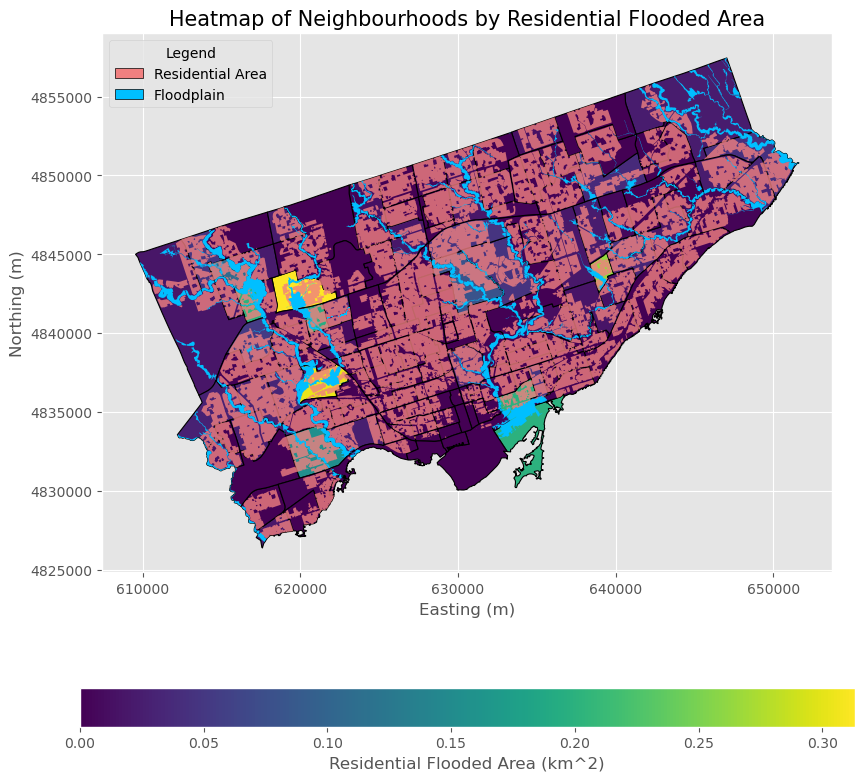

In [57]:
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed
neighbourhoods_copy.plot(column='Residential area flooded', 
                         cmap='viridis',  
                         linewidth=0.8, 
                         ax=ax, 
                         edgecolor='k',  # Adds a black border around each neighborhood
                         legend=True,  # Adds a legend for color mapping
                         legend_kwds={'label': "Residential Flooded Area (km^2)",
                                      'orientation': "horizontal"})
#Overlay the residential area
aggregated_zones.iloc[[4]].plot(ax=ax, color='lightcoral', linewidth=1, alpha=0.8)  

#Overlay the flood plain
flood_plain.plot(ax=ax, color=(0/255, 191/255, 255/255), linewidth=1, alpha=1)  

legend_elements = [
    Patch(facecolor='lightcoral', edgecolor='k', label='Residential Area'),
    Patch(facecolor=(0/255, 191/255, 255/255), edgecolor='k', label='Floodplain')
]
ax.legend(handles=legend_elements, loc='upper left', title="Legend")

# Add title and labels
ax.set_title("Heatmap of Neighbourhoods by Residential Flooded Area", fontsize=15)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
# Ensure axis ticks are not in scientific notation
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)  # Disable scientific notation

ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Show plot
plt.show()

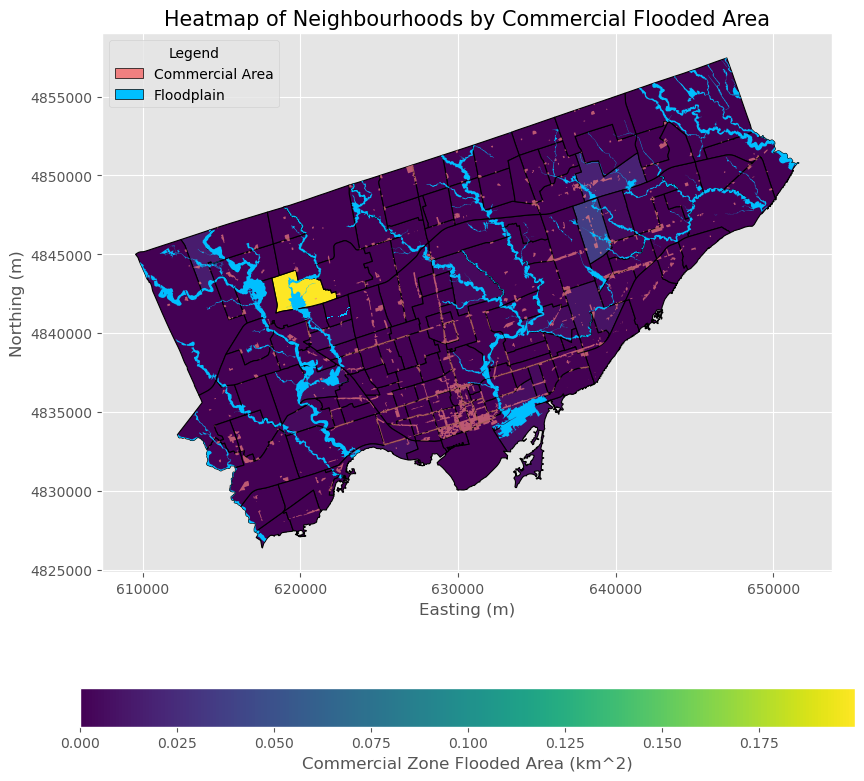

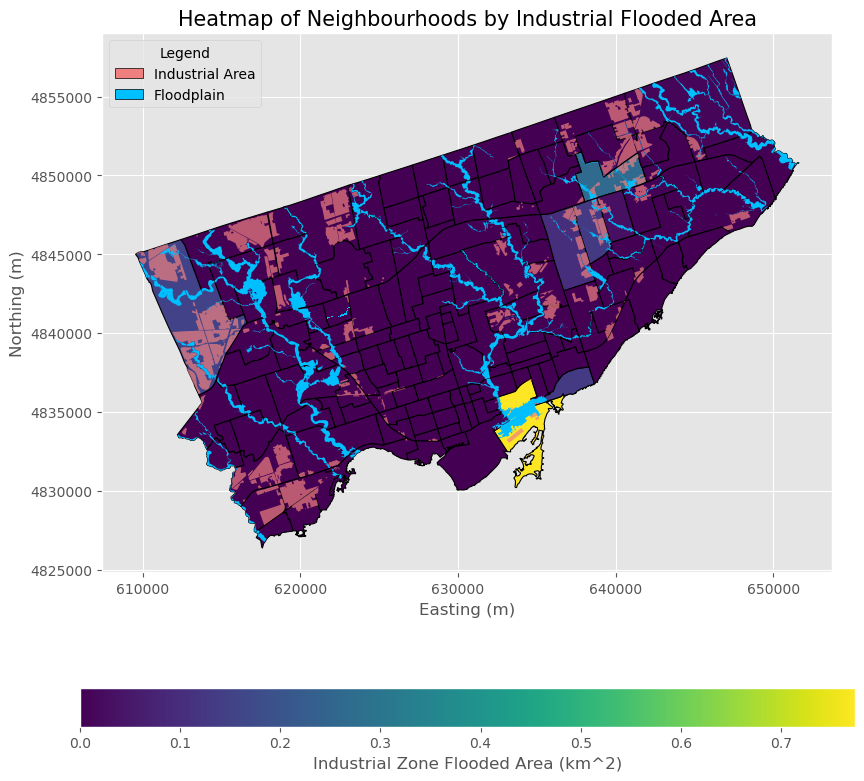

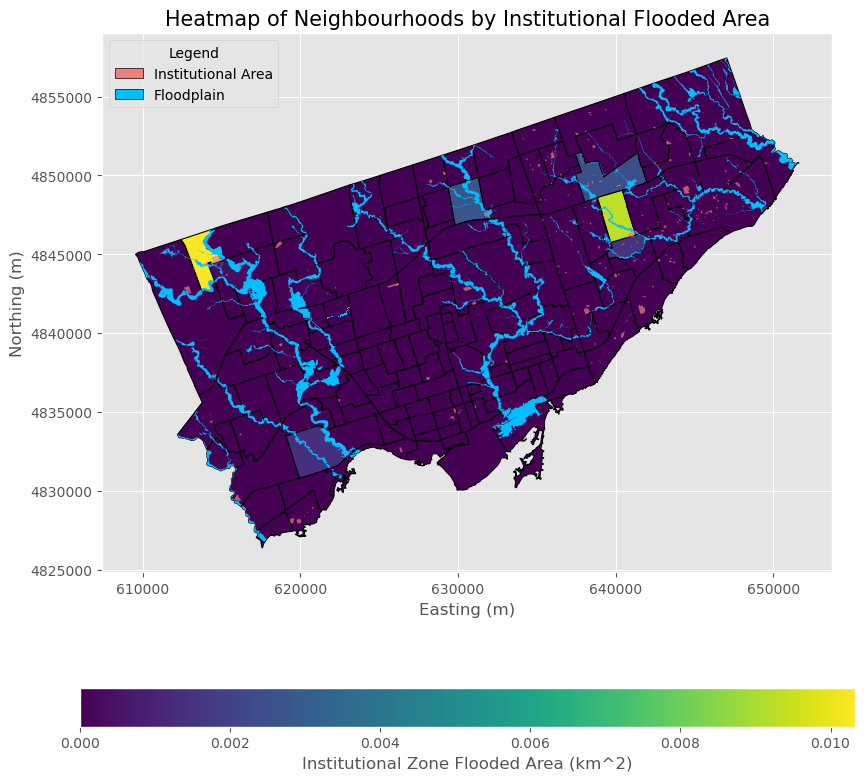

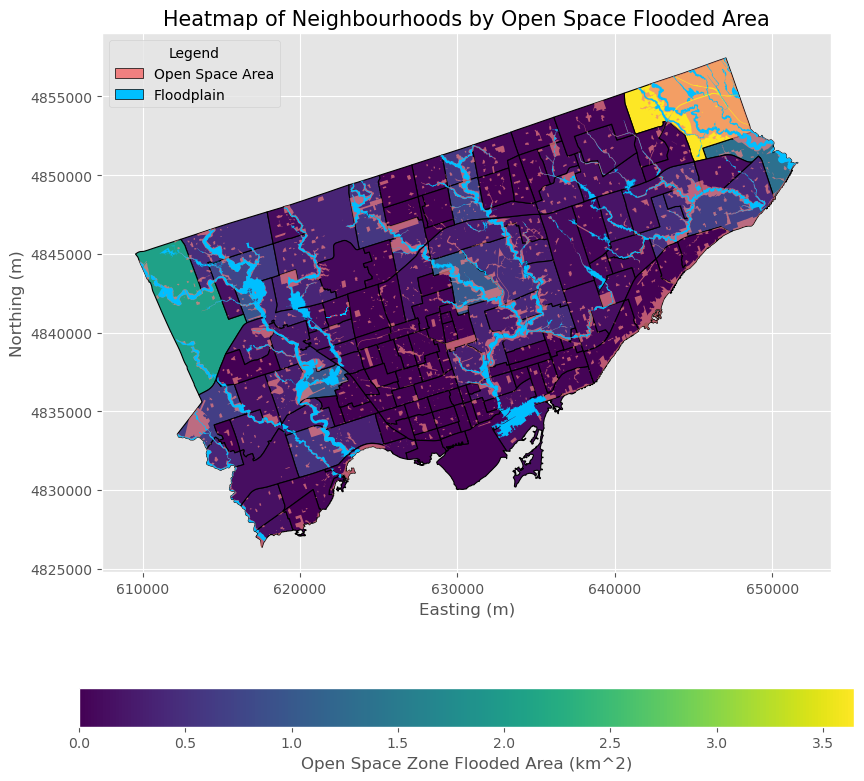

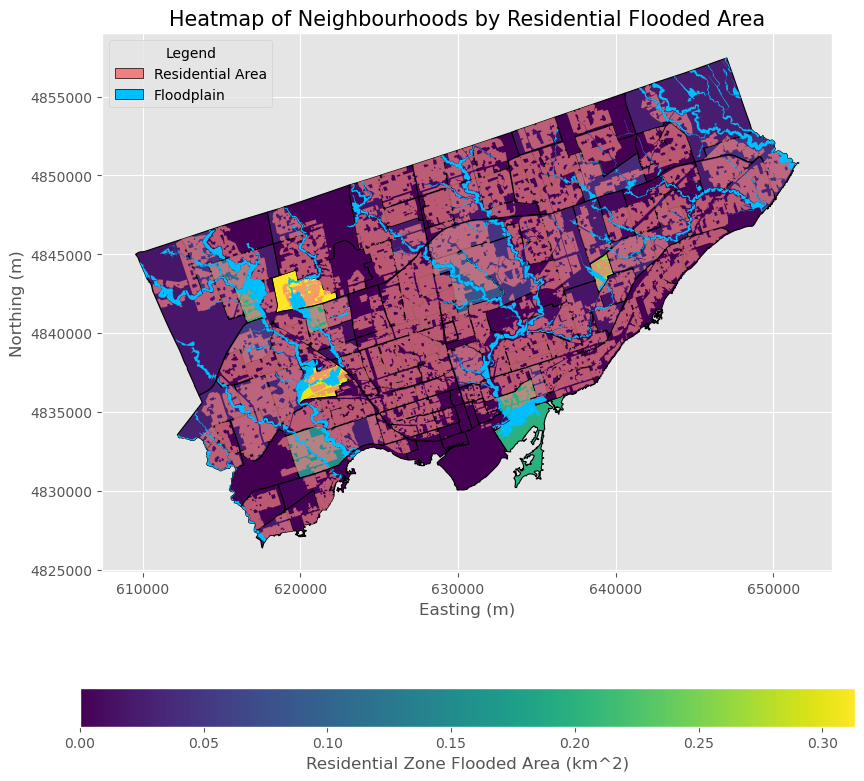

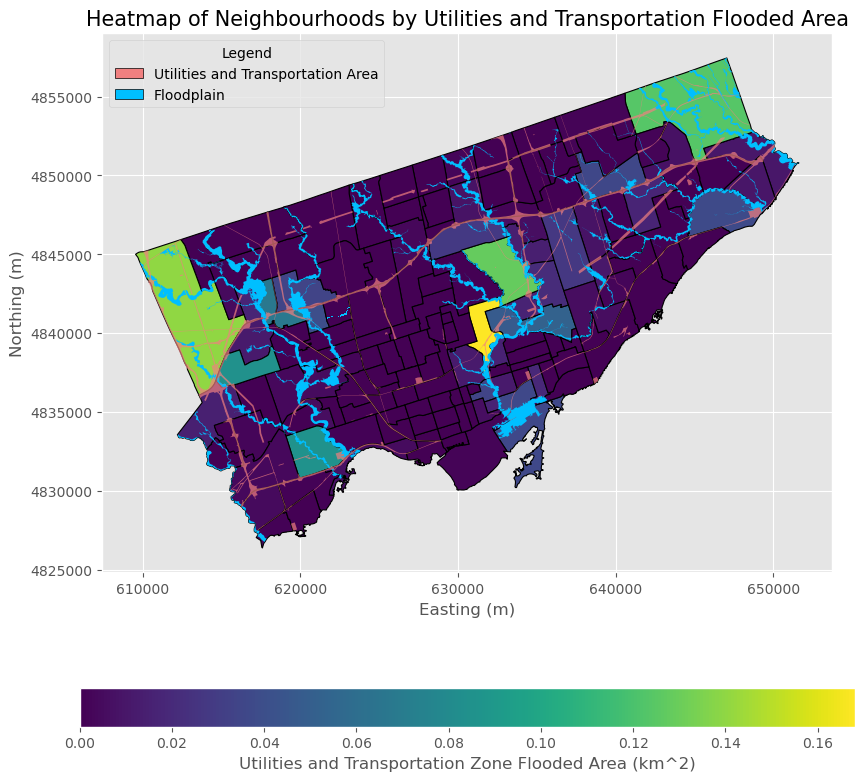

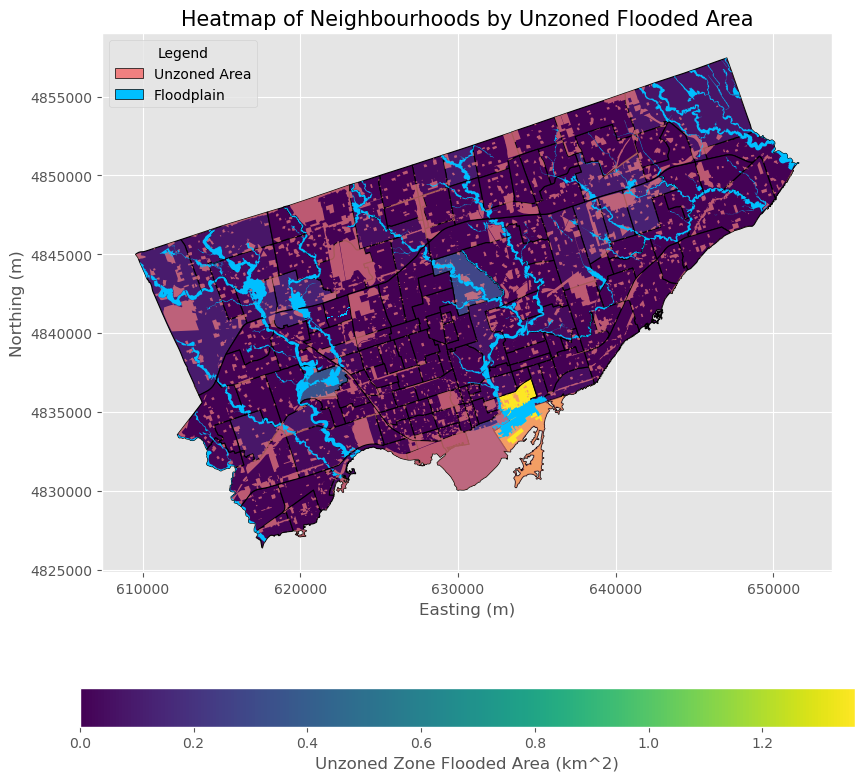

In [58]:
# We can do same exercise for each zone type

zone_types = ['Commercial', 'Industrial', 'Institutional', 'Open Space', 
              'Residential', 'Utilities and Transportation', 'Unzoned']

# Create 7 plots, one for each zone type
for zone_type in zone_types:
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed
    
    # Plot the heatmap for the current zone type
    neighbourhoods_copy.plot(
        column=f'{zone_type} area flooded',  # Use the zone type in the column name
        cmap='viridis',  # Color map for heatmap
        linewidth=0.8, 
        ax=ax, 
        edgecolor='k',  # Adds a black border around each neighborhood
        legend=True,  # Adds a legend for color mapping
        legend_kwds={
            'label': f"{zone_type} Zone Flooded Area (km^2)",
            'orientation': "horizontal"
        }
    )

    # Overlay the specific zone area (the row corresponding to the zone type)
    zone_row = aggregated_zones[aggregated_zones['Zone_type'] == zone_type]
    if not zone_row.empty:
        zone_row.plot(ax=ax, color='lightcoral', linewidth=1, alpha=0.7)
    
    # Overlay the flood plain
    flood_plain.plot(ax=ax, color=(0/255, 191/255, 255/255), linewidth=1, alpha=1)  

    # Custom legend for zone and floodplain
    legend_elements = [
        Patch(facecolor='lightcoral', edgecolor='k', label=f'{zone_type} Area'),
        Patch(facecolor=(0/255, 191/255, 255/255), edgecolor='k', label='Floodplain')
    ]
    ax.legend(handles=legend_elements, loc='upper left', title="Legend")

    # Add title and labels
    ax.set_title(f"Heatmap of Neighbourhoods by {zone_type} Flooded Area", fontsize=15)
    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Northing (m)')
    # Ensure axis ticks are not in scientific notation
    formatter = ScalarFormatter(useOffset=False)
    formatter.set_scientific(False)  # Disable scientific notation

    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    # Show the plot
    plt.show()

### Let's plot and bring in vulnerability index/demographics data

In [83]:
# Open vulnerability index data
vulnerability_df = pd.read_csv('selected_columns.csv')
vulnerability_df

Neighbourhood_name  normalized_V_CT
0               West Humber-Clairville         0.662516
1    Mount Olive-Silverstone-Jamestown         0.994211
2         Thistletown-Beaumond Heights         0.101900
3                      Rexdale-Kipling         0.143595
4                     Elms-Old Rexdale         0.140557
..                                 ...              ...
146                 Yonge-Bay Corridor         0.276378
147           Junction-Wallace Emerson         0.410189
148                 Dovercourt Village         0.099997
149                      North Toronto         0.592042
150          South Eglinton-Davisville         0.679154

[151 rows x 2 columns]

In [84]:
#recall neighbourhood df
neighbourhoods_copy

Neighbourhood_name  \
_id                                 
150              Elms-Old Rexdale   
77              Rockcliffe-Smythe   
152  Thistletown-Beaumond Heights   
86                South Riverdale   
74             Lambton Baby Point   
..                            ...   
65         Corso Italia-Davenport   
64                       Wychwood   
63                          Annex   
62                      Casa Loma   
80                     University   

                                              geometry       Area  \
_id                                                                 
150  MULTIPOLYGON (((617036.099 4843084.408, 617072...   2.931077   
77   MULTIPOLYGON (((622906.715 4837589.820, 622945...   5.070942   
152  MULTIPOLYGON (((615765.096 4844414.710, 615759...   3.339552   
86   MULTIPOLYGON (((634777.162 4835393.561, 634781...  11.030185   
74   MULTIPOLYGON (((620997.191 4835850.694, 620999...   1.782160   
..                                                 ...        ...   
65   MULTIPOLYGON (((625452.962 4837670.198, 625547...   1.889356   
64   MULTIPOLYGON (((627500.398 4837848.962, 627527...   1.682042   
63   MULTIPOLYGON (((627613.208 4835753.867, 627517...   2.790299   
62   MULTIPOLYGON (((628942.392 4837967.303, 628945...   1.922412   
80   MULTIPOLYGON (((629043.882 4835131.447, 629033...   1.405204   

     flood_intersection_area  Proportion Neighbourhood flooded  \
_id                                                              
150                 1.208703                          0.412375   
77                  1.660268                          0.327408   
152                 0.889458                          0.266341   
86                  2.500970                          0.226739   
74                  0.351825                          0.197415   
..                       ...                               ...   
65                  0.000000                          0.000000   
64                  0.000000                          0.000000   
63                  0.000000                          0.000000   
62                  0.000000                          0.000000   
80                  0.000000                          0.000000   

     Proportion of flood that is Neighbourhood  Percent Neighbourhood Flooded  \
_id                                                                             
150                                   0.028788                      41.237492   
77                                    0.039542                      32.740808   
152                                   0.021184                      26.634067   
86                                    0.059565                      22.673867   
74                                    0.008379                      19.741502   
..                                         ...                            ...   
65                                    0.000000                       0.000000   
64                                    0.000000                       0.000000   
63                                    0.000000                       0.000000   
62                                    0.000000                       0.000000   
80                                    0.000000                       0.000000   

     Greenspace_area  Proportion Greenspace  Greenspace_flooded_area  ...  \
_id                                                                   ...   
150         0.737576               0.251640                 0.551077  ...   
77          0.593422               0.117024                 0.341783  ...   
152         0.957007               0.286568                 0.743371  ...   
86          2.787658               0.252730                 0.040405  ...   
74          0.476740               0.267507                 0.309836  ...   
..               ...                    ...                      ...  ...   
65          0.127460               0.067462                 0.000000  ...   
64          0.066152         

In [85]:
# Add vulnerability and population columns 

# Save the original index before merging
neighbourhoods_copy['original_index'] = neighbourhoods_copy.index

# Perform the merge using 'Neighbourhood_name' column
neighbourhoods_copy = neighbourhoods_copy.merge(
    vulnerability_df[['Neighbourhood_name', 'normalized_V_CT']],  # Select the column to merge
    how='left',  # Left join ensures all rows from neighbourhoods_copy are kept
    on='Neighbourhood_name'  # Merge based on 'Neighbourhood_name'
)

# Fill NaN values in 'normalized_V_CT' with mean
mean_value = neighbourhoods_copy['normalized_V_CT'].mean()
neighbourhoods_copy['normalized_V_CT'] = neighbourhoods_copy['normalized_V_CT'].fillna(mean_value)

# Set the original index back
neighbourhoods_copy.set_index('original_index', inplace=True)

neighbourhoods_copy

Neighbourhood_name  \
original_index                                 
150                         Elms-Old Rexdale   
77                         Rockcliffe-Smythe   
152             Thistletown-Beaumond Heights   
86                           South Riverdale   
74                        Lambton Baby Point   
...                                      ...   
65                    Corso Italia-Davenport   
64                                  Wychwood   
63                                     Annex   
62                                 Casa Loma   
80                                University   

                                                         geometry       Area  \
original_index                                                                 
150             MULTIPOLYGON (((617036.099 4843084.408, 617072...   2.931077   
77              MULTIPOLYGON (((622906.715 4837589.820, 622945...   5.070942   
152             MULTIPOLYGON (((615765.096 4844414.710, 615759...   3.339552   
86              MULTIPOLYGON (((634777.162 4835393.561, 634781...  11.030185   
74              MULTIPOLYGON (((620997.191 4835850.694, 620999...   1.782160   
...                                                           ...        ...   
65              MULTIPOLYGON (((625452.962 4837670.198, 625547...   1.889356   
64              MULTIPOLYGON (((627500.398 4837848.962, 627527...   1.682042   
63              MULTIPOLYGON (((627613.208 4835753.867, 627517...   2.790299   
62              MULTIPOLYGON (((628942.392 4837967.303, 628945...   1.922412   
80              MULTIPOLYGON (((629043.882 4835131.447, 629033...   1.405204   

                flood_intersection_area  Proportion Neighbourhood flooded  \
original_index                                                              
150                            1.208703                          0.412375   
77                             1.660268                          0.327408   
152                            0.889458                          0.266341   
86                             2.500970                          0.226739   
74                             0.351825                          0.197415   
...                                 ...                               ...   
65                             0.000000                          0.000000   
64                             0.000000                          0.000000   
63                             0.000000                          0.000000   
62                             0.000000                          0.000000   
80                             0.000000                          0.000000   

                Proportion of flood that is Neighbourhood  \
original_index                                              
150                                              0.028788   
77                                               0.039542   
152                                              0.021184   
86                                               0.059565   
74                                               0.008379   
...                                                   ...   
65                                               0.000000   
64                                               0.000000   
63                                               0.000000   
62                                               0.000000   
80                                               0.000000   

                Percent Neighbourhood Flooded  Greenspace_area  \
original_index                                                   
150                                 41.237492         0.737576   
77                                  32.740808         0.593422   
152                                 26.634067         0.957007   
86                                  22.673867         2.787658   
74                                  19.741502         0.476740   
...                                       ...              ...   
65                                  

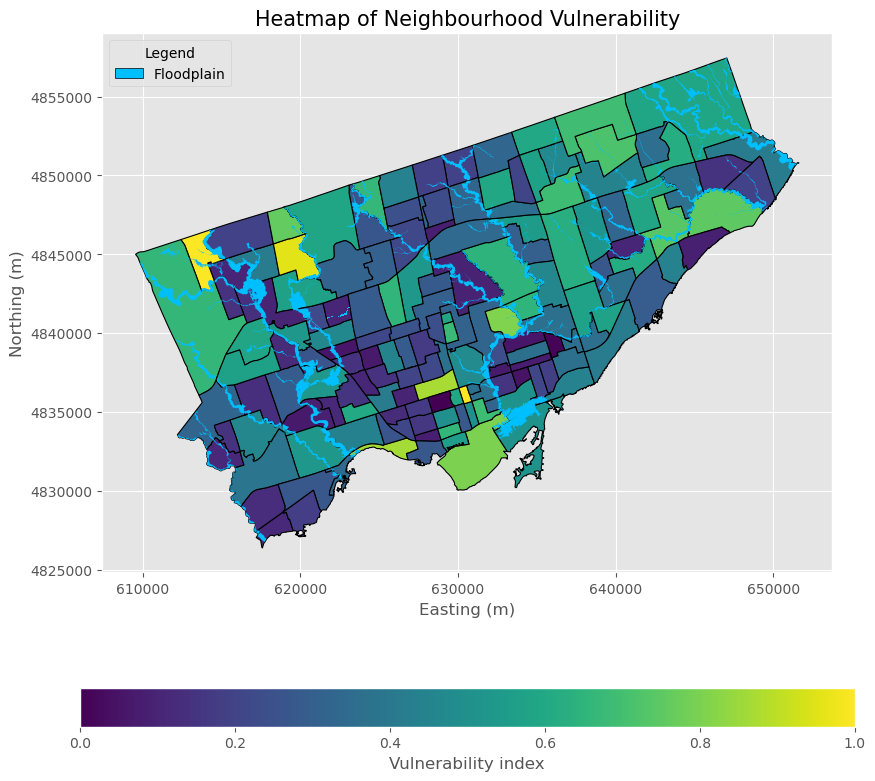

In [86]:
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed
neighbourhoods_copy.plot(column='normalized_V_CT', 
                         cmap='viridis',  
                         linewidth=0.8, 
                         ax=ax, 
                         edgecolor='k',  # Adds a black border around each neighborhood
                         legend=True,  # Adds a legend for color mapping
                         legend_kwds={'label': "Vulnerability index",
                                      'orientation': "horizontal"})


#Overlay the flood plain
flood_plain.plot(ax=ax, color=(0/255, 191/255, 255/255), linewidth=1, alpha=1)  

legend_elements = [
#     Patch(facecolor='forestgreen', edgecolor='k', label='Greenspace'),
    Patch(facecolor=(0/255, 191/255, 255/255), edgecolor='k', label='Floodplain')
]
ax.legend(handles=legend_elements, loc='upper left', title="Legend")

# Add title and labels
ax.set_title("Heatmap of Neighbourhood Vulnerability", fontsize=15)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
# Ensure axis ticks are not in scientific notation
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)  # Disable scientific notation

ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Show plot
plt.show()

In [87]:
neighbourhoods_copy.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 158 entries, 150 to 80
Data columns (total 43 columns):
 #   Column                                                            Non-Null Count  Dtype   
---  ------                                                            --------------  -----   
 0   Neighbourhood_name                                                158 non-null    object  
 1   geometry                                                          158 non-null    geometry
 2   Area                                                              158 non-null    float64 
 3   flood_intersection_area                                           158 non-null    float64 
 4   Proportion Neighbourhood flooded                                  158 non-null    float64 
 5   Proportion of flood that is Neighbourhood                         158 non-null    float64 
 6   Percent Neighbourhood Flooded                                     158 non-null    float64 
 7   Greenspace_area       

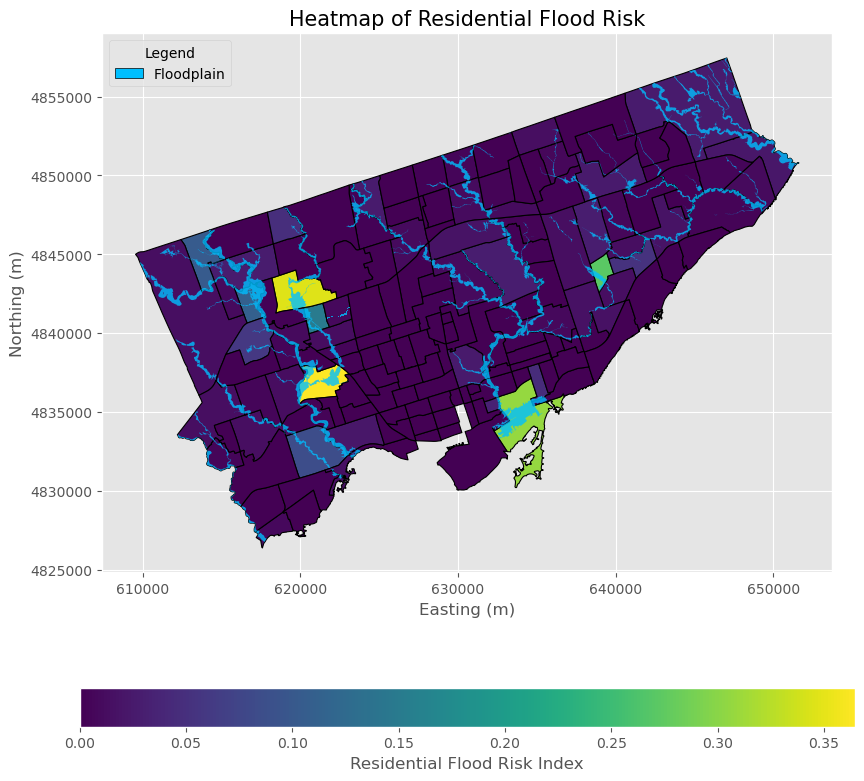

In [90]:
### Now let's consider vulnerability times % residential flooded = residential flood risk
neighbourhoods_copy['Normalized Proportion Residential Flooded'] = (neighbourhoods_copy['Residential proportion flooded in neighbourhood']- neighbourhoods_copy['Residential proportion flooded in neighbourhood'].min())/(neighbourhoods_copy['Residential proportion flooded in neighbourhood'].max()- neighbourhoods_copy['Residential proportion flooded in neighbourhood'].min())
                                                                    
                                                                    
neighbourhoods_copy['Residential Flood Risk'] = neighbourhoods_copy['Normalized Proportion Residential Flooded'] * neighbourhoods_copy['normalized_V_CT']

fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed
neighbourhoods_copy.plot(column='Residential Flood Risk', 
                         cmap='viridis',  
                         linewidth=0.8, 
                         ax=ax, 
                         edgecolor='k',  # Adds a black border around each neighborhood
                         legend=True,  # Adds a legend for color mapping
                         legend_kwds={'label': "Residential Flood Risk Index",
                                      'orientation': "horizontal"})


#Overlay the flood plain
flood_plain.plot(ax=ax, color=(0/255, 191/255, 255/255), linewidth=1, alpha=0.8)  

legend_elements = [
#     Patch(facecolor='forestgreen', edgecolor='k', label='Greenspace'),
    Patch(facecolor=(0/255, 191/255, 255/255), edgecolor='k', label='Floodplain')
]
ax.legend(handles=legend_elements, loc='upper left', title="Legend")

# Add title and labels
ax.set_title("Heatmap of Residential Flood Risk", fontsize=15)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
# Ensure axis ticks are not in scientific notation
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)  # Disable scientific notation

ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Show plot
plt.show()

In [91]:
neighbourhoods_copy.sort_values(by ='Residential Flood Risk', ascending = False)

Neighbourhood_name  \
original_index                              
77                      Rockcliffe-Smythe   
9                Oakdale-Beverley Heights   
86                        South Riverdale   
34                                Ionview   
125                                Rustic   
...                                   ...   
73                           Mount Dennis   
80                             University   
43              Fort York-Liberty Village   
41                 Harbourfront-CityPlace   
5                      Yonge-Bay Corridor   

                                                         geometry       Area  \
original_index                                                                 
77              MULTIPOLYGON (((622906.715 4837589.820, 622945...   5.070942   
9               MULTIPOLYGON (((619836.390 4843468.484, 619870...   6.685141   
86              MULTIPOLYGON (((634777.162 4835393.561, 634781...  11.030185   
34              MULTIPOLYGON (((638977.705 4842578.494, 638956...   1.952896   
125             MULTIPOLYGON (((620563.157 4839965.013, 620551...   2.096378   
...                                                           ...        ...   
73              MULTIPOLYGON (((620872.455 4839006.331, 621070...   2.129362   
80              MULTIPOLYGON (((629043.882 4835131.447, 629033...   1.405204   
43              MULTIPOLYGON (((628412.707 4833131.331, 628423...   2.339540   
41              MULTIPOLYGON (((630652.154 4833152.426, 630662...   1.138334   
5               MULTIPOLYGON (((630329.072 4833709.787, 630250...   1.118725   

                flood_intersection_area  Proportion Neighbourhood flooded  \
original_index                                                              
77                             1.660268                          0.327408   
9                              1.054867                          0.157793   
86                             2.500970                          0.226739   
34                             0.340340                          0.174274   
125                            0.374347                          0.178568   
...                                 ...                               ...   
73                             0.408756                          0.191962   
80                             0.000000                          0.000000   
43                             0.000000                          0.000000   
41                             0.000000                          0.000000   
5                              0.000000                          0.000000   

                Proportion of flood that is Neighbourhood  \
original_index                                              
77                                               0.039542   
9                                                0.025124   
86                                               0.059565   
34                                               0.008106   
125                                              0.008916   
...                                                   ...   
73                                               0.009735   
80                                               0.000000   
43                                               0.000000   
41                                               0.000000   
5                                                0.000000   

                Percent Neighbourhood Flooded  Greenspace_area  \
original_index                                                   
77                                  32.740808         0.593422   
9                                   15.779274         0.451262   
86                                  22.673867         2.787658   
34                                  17.427430         0.134040   
125                                 17.856833         0.202267   
...                                       ...              ...   
73                                  19.196198         0.675493   
80    

In [92]:
neighbourhoods_copy[neighbourhoods_copy['Neighbourhood_name'] == "Elms-Old Rexdale"]

Neighbourhood_name  \
original_index                      
150              Elms-Old Rexdale   

                                                         geometry      Area  \
original_index                                                                
150             MULTIPOLYGON (((617036.099 4843084.408, 617072...  2.931077   

                flood_intersection_area  Proportion Neighbourhood flooded  \
original_index                                                              
150                            1.208703                          0.412375   

                Proportion of flood that is Neighbourhood  \
original_index                                              
150                                              0.028788   

                Percent Neighbourhood Flooded  Greenspace_area  \
original_index                                                   
150                                 41.237492         0.737576   

                Proportion Greenspace  Greenspace_flooded_area  ...  \
original_index                                                  ...   
150                           0.25164                 0.551077  ...   

                Utilities and Transportation area flooded  \
original_index                                              
150                                              0.017007   

                Utilities and Transportation area not flooded  \
original_index                                                  
150                                                  0.149723   

                Utilities and Transportation proportion flooded in neighbourhood  \
original_index                                                                     
150                                                      0.102004                  

                Unzoned area  Unzoned area flooded  Unzoned area not flooded  \
original_index                                                                 
150                 0.203521              0.042353                  0.161168   

                Unzoned proportion flooded in neighbourhood  normalized_V_CT  \
original_index                                                                 
150                                                0.208103         0.140557   

                Normalized Proportion Residential Flooded  \
original_index                                              
150                                              0.783508   

                Residential Flood Risk  
original_index                          
150                           0.110127  

[1 rows x 45 columns]

## Now let's do similar exercise but considering flooding is WORSE...

In [94]:
#recall flood_plain
flood_plain

geometry       Area
0  MULTIPOLYGON (((617386.706 4827247.947, 617400...  41.986941

In [113]:
invalid_geometries1 = flood_plain[~flood_plain.is_valid]
invalid_geometries1

Empty GeoDataFrame
Columns: [geometry, Area]
Index: []

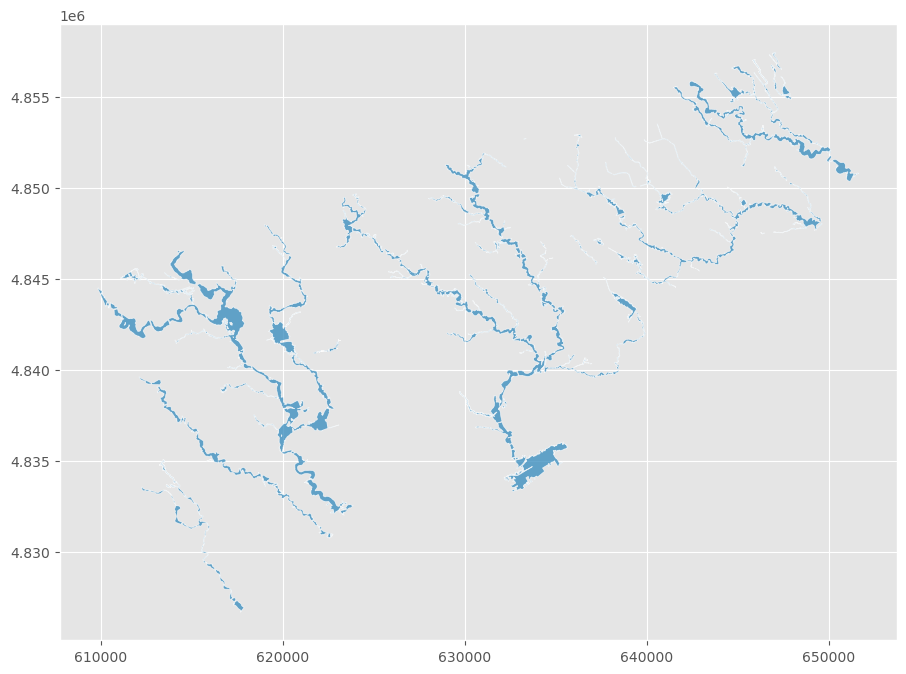

In [96]:
flood_plains.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);

<Axes: >

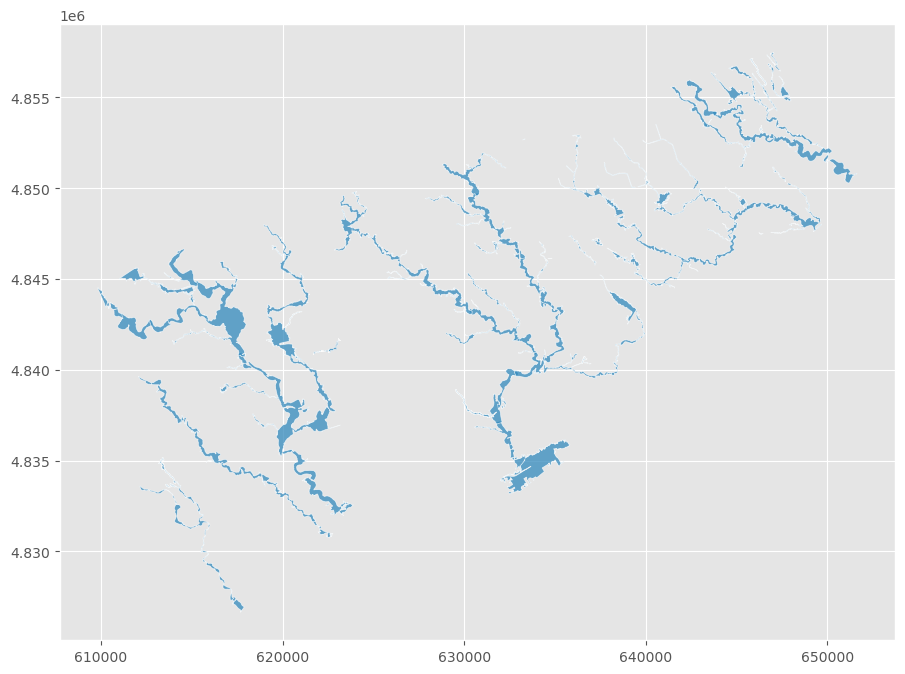

In [114]:
# Create function that makes multipolygon bigger by some factor
# Factor is determined by climate change analysis

# Function to scale a MultiPolygon by a factor
def scale_multipolygon(multipolygon, factor):
    # Create a list to store the scaled polygons
    scaled_polygons = []

    # Iterate over each polygon in the MultiPolygon
    for polygon in multipolygon.geoms:
        # Get the centroid of the polygon
        centroid = polygon.centroid
        
        # Create a list of new coordinates for the scaled polygon
        new_coords = []
        
        # Iterate over the polygon's exterior coordinates
        for x, y in polygon.exterior.coords:
            # Calculate the direction vector from the centroid
            dx, dy = x - centroid.x, y - centroid.y
            
            # Scale the direction vector by the factor
            new_x = centroid.x + dx * factor
            new_y = centroid.y + dy * factor
            
            new_coords.append((new_x, new_y))
        
        # Create a new scaled polygon
        new_polygon = Polygon(new_coords)
        
        # Validate the new polygon (fix invalid geometry if necessary)
        if not new_polygon.is_valid:
            new_polygon = new_polygon.buffer(0)  # Fix self-intersections and other issues
        
        scaled_polygons.append(new_polygon)

    # Return a MultiPolygon made up of the scaled polygons
    return MultiPolygon(scaled_polygons)

# Apply the scaling to flood_plain geometry
flood_plain_worse = scale_multipolygon(flood_plain.geometry.iloc[0], 1.1)

# Create a GeoDataFrame with the scaled geometry
flood_plain_worse_gdf = gpd.GeoDataFrame({'geometry': [flood_plain_worse]}, crs=flood_plains.crs)

# Plot to check visually
flood_plain_worse_gdf.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)

In [117]:
def scale_and_separate_multipolygon(multipolygon, factor):
    # Scale each polygon in the MultiPolygon separately
    scaled_polygons = []
    for polygon in multipolygon.geoms:
        # Get the centroid of the polygon
        centroid = polygon.centroid
        
        # Create a list of new coordinates for the scaled polygon
        new_coords = []
        for x, y in polygon.exterior.coords:
            dx, dy = x - centroid.x, y - centroid.y
            new_x = centroid.x + dx * factor
            new_y = centroid.y + dy * factor
            new_coords.append((new_x, new_y))
        
        # Create a new scaled polygon
        new_polygon = Polygon(new_coords)
        
        # Check if the new polygon is valid
        if not new_polygon.is_valid:
            new_polygon = new_polygon.buffer(0)  # Fix self-intersections and other issues
            
        scaled_polygons.append(new_polygon)

    # Return the MultiPolygon made up of the scaled polygons
    return MultiPolygon(scaled_polygons)

# Apply the scaling and check for intersection after scaling
flood_plain_worse = scale_and_separate_multipolygon(flood_plain.geometry.iloc[0], 1.1)

# Apply a small buffer to fix potential intersections
flood_plain_worse = flood_plain_worse.buffer(0.001, resolution=16)

# Create a GeoDataFrame with the fixed geometry
flood_plain_worse_gdf = gpd.GeoDataFrame({'geometry': [flood_plain_worse]}, crs=flood_plains.crs)
invalid_geometries = flood_plain_worse_gdf[~flood_plain_worse_gdf.is_valid]
invalid_geometries

Empty GeoDataFrame
Columns: [geometry]
Index: []

In [118]:
# Check area, should be more by a bit
flood_plain_worse_gdf['Area'] =flood_plain_worse_gdf.geometry.area / (1000**2)
flood_plain_worse_gdf

geometry       Area
0  MULTIPOLYGON (((650003.799 4851825.784, 650003...  50.527593

In [103]:
# Recall df
neighbourhoods_copy

Neighbourhood_name  \
original_index                                 
150                         Elms-Old Rexdale   
77                         Rockcliffe-Smythe   
152             Thistletown-Beaumond Heights   
86                           South Riverdale   
74                        Lambton Baby Point   
...                                      ...   
65                    Corso Italia-Davenport   
64                                  Wychwood   
63                                     Annex   
62                                 Casa Loma   
80                                University   

                                                         geometry       Area  \
original_index                                                                 
150             MULTIPOLYGON (((617036.099 4843084.408, 617072...   2.931077   
77              MULTIPOLYGON (((622906.715 4837589.820, 622945...   5.070942   
152             MULTIPOLYGON (((615765.096 4844414.710, 615759...   3.339552   
86              MULTIPOLYGON (((634777.162 4835393.561, 634781...  11.030185   
74              MULTIPOLYGON (((620997.191 4835850.694, 620999...   1.782160   
...                                                           ...        ...   
65              MULTIPOLYGON (((625452.962 4837670.198, 625547...   1.889356   
64              MULTIPOLYGON (((627500.398 4837848.962, 627527...   1.682042   
63              MULTIPOLYGON (((627613.208 4835753.867, 627517...   2.790299   
62              MULTIPOLYGON (((628942.392 4837967.303, 628945...   1.922412   
80              MULTIPOLYGON (((629043.882 4835131.447, 629033...   1.405204   

                flood_intersection_area  Proportion Neighbourhood flooded  \
original_index                                                              
150                            1.208703                          0.412375   
77                             1.660268                          0.327408   
152                            0.889458                          0.266341   
86                             2.500970                          0.226739   
74                             0.351825                          0.197415   
...                                 ...                               ...   
65                             0.000000                          0.000000   
64                             0.000000                          0.000000   
63                             0.000000                          0.000000   
62                             0.000000                          0.000000   
80                             0.000000                          0.000000   

                Proportion of flood that is Neighbourhood  \
original_index                                              
150                                              0.028788   
77                                               0.039542   
152                                              0.021184   
86                                               0.059565   
74                                               0.008379   
...                                                   ...   
65                                               0.000000   
64                                               0.000000   
63                                               0.000000   
62                                               0.000000   
80                                               0.000000   

                Percent Neighbourhood Flooded  Greenspace_area  \
original_index                                                   
150                                 41.237492         0.737576   
77                                  32.740808         0.593422   
152                                 26.634067         0.957007   
86                                  22.673867         2.787658   
74                                  19.741502         0.476740   
...                                       ...              ...   
65                                  

In [123]:
# Let's determine areas of zones flooded using similar process, except with worse flood plain

#We need to determine similar columns for each zone

# Iterate through each row in 'aggregated_zones'
for index, row in aggregated_zones.iterrows():
    
    zone_type = row['Zone_type']
    
    # Area of zone flooded (intersection of the zone and the "worse-case" floodplain)
    flooded_area_column = f"{zone_type} area flooded (worse case)"
    not_flooded_area_column = f"{zone_type} area not flooded (worse case)"
    proportion_flooded_column = f"{zone_type} proportion flooded (worse case) in neighbourhood"
    
    # Perform the intersection calculation
    # Intersection of the zone geometry with the floodplain geometry (assuming the floodplain is the first one)
    intersection = neighbourhoods_copy.geometry.intersection(row.geometry).intersection(flood_plain_worse_gdf.geometry.iloc[0])

    # Calculate area flooded (in square kilometers)
    neighbourhoods_copy[flooded_area_column] = intersection.area / (1000**2)

    # Area of zone not flooded (subtract flooded area from total zone area)
    neighbourhoods_copy[not_flooded_area_column] = neighbourhoods_copy[str(zone_type + " area")] - neighbourhoods_copy[flooded_area_column]

    # Proportion of zone flooded
    neighbourhoods_copy[proportion_flooded_column] = neighbourhoods_copy[flooded_area_column] / neighbourhoods_copy[str(zone_type + " area")]

# Check new columns
neighbourhoods_copy.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 158 entries, 150 to 80
Data columns (total 66 columns):
 #   Column                                                                         Non-Null Count  Dtype   
---  ------                                                                         --------------  -----   
 0   Neighbourhood_name                                                             158 non-null    object  
 1   geometry                                                                       158 non-null    geometry
 2   Area                                                                           158 non-null    float64 
 3   flood_intersection_area                                                        158 non-null    float64 
 4   Proportion Neighbourhood flooded                                               158 non-null    float64 
 5   Proportion of flood that is Neighbourhood                                      158 non-null    float64 
 6   Percent Neighb

In [127]:
# Now let's compare how much worse it got by zones
# Calculate the area of the intersection (in square units of the CRS)
aggregated_zones['Worse case flood area'] = aggregated_zones.geometry.intersection(flood_plain_worse_gdf.geometry.iloc[0]).area /(1000**2)

# Calculate the total area of the flood plain
flood_plain_area_worse = flood_plain_worse_gdf['Area'].iloc[0]

# Calculate the proportion of each zone's intersection with the flood plain
aggregated_zones['Proportion zone flooded worse'] = aggregated_zones['Worse case flood area'] / aggregated_zones['Area']

aggregated_zones['Proportion of (worse) flood that is Zone'] = aggregated_zones['Worse case flood area'] / flood_plain_area_worse

# Result
aggregated_zones

Zone_type  \
0                    Commercial   
1                    Industrial   
2                 Institutional   
3                    Open Space   
4                   Residential   
5  Utilities and Transportation   
6                       Unzoned   

                                            geometry        Area  \
0  MULTIPOLYGON (((618990.583 4828066.368, 618990...   21.617256   
1  MULTIPOLYGON (((612550.196 4833612.192, 612543...   56.652189   
2  MULTIPOLYGON (((619949.302 4828228.490, 619947...    3.289453   
3  MULTIPOLYGON (((616610.108 4828600.809, 616622...  105.547687   
4  MULTIPOLYGON (((614483.200 4831594.391, 614484...  302.173822   
5  MULTIPOLYGON (((616646.202 4830760.693, 616594...   31.396594   
6  MULTIPOLYGON (((619381.385 4827411.241, 619389...  122.309237   

   flood_intersection_area  Proportion_zone_flooded  \
0                 0.332968                 0.015403   
1                 1.623952                 0.028665   
2                 0.028215                 0.008577   
3                31.227622                 0.295863   
4                 2.923623                 0.009675   
5                 1.490300                 0.047467   
6                 4.361811                 0.035662   

   Proportion of flood that is Zone  Worse case flood area  \
0                          0.007930               0.492572   
1                          0.038678               2.028362   
2                          0.000672               0.113922   
3                          0.743746              32.919594   
4                          0.069632               6.396935   
5                          0.035494               2.346210   
6                          0.103885               5.808523   

   Proportion zone flooded worse  Proportion of (worse) flood that is Zone  
0                       0.022786                                  0.009749  
1                       0.035804                                  0.040144  
2                       0.034633                                  0.002255  
3                       0.311893                                  0.651517  
4                       0.021170                                  0.126603  
5                       0.074728                                  0.046434  
6                       0.047490                                  0.114957

In [130]:
# Let's determine percent increase
aggregated_zones['Percent change in flooding area'] = 100*(aggregated_zones['Worse case flood area']-aggregated_zones['flood_intersection_area'])/(aggregated_zones['flood_intersection_area'])

aggregated_zones

Zone_type  \
0                    Commercial   
1                    Industrial   
2                 Institutional   
3                    Open Space   
4                   Residential   
5  Utilities and Transportation   
6                       Unzoned   

                                            geometry        Area  \
0  MULTIPOLYGON (((618990.583 4828066.368, 618990...   21.617256   
1  MULTIPOLYGON (((612550.196 4833612.192, 612543...   56.652189   
2  MULTIPOLYGON (((619949.302 4828228.490, 619947...    3.289453   
3  MULTIPOLYGON (((616610.108 4828600.809, 616622...  105.547687   
4  MULTIPOLYGON (((614483.200 4831594.391, 614484...  302.173822   
5  MULTIPOLYGON (((616646.202 4830760.693, 616594...   31.396594   
6  MULTIPOLYGON (((619381.385 4827411.241, 619389...  122.309237   

   flood_intersection_area  Proportion_zone_flooded  \
0                 0.332968                 0.015403   
1                 1.623952                 0.028665   
2                 0.028215                 0.008577   
3                31.227622                 0.295863   
4                 2.923623                 0.009675   
5                 1.490300                 0.047467   
6                 4.361811                 0.035662   

   Proportion of flood that is Zone  Worse case flood area  \
0                          0.007930               0.492572   
1                          0.038678               2.028362   
2                          0.000672               0.113922   
3                          0.743746              32.919594   
4                          0.069632               6.396935   
5                          0.035494               2.346210   
6                          0.103885               5.808523   

   Proportion zone flooded worse  Proportion of (worse) flood that is Zone  \
0                       0.022786                                  0.009749   
1                       0.035804                                  0.040144   
2                       0.034633                                  0.002255   
3                       0.311893                                  0.651517   
4                       0.021170                                  0.126603   
5                       0.074728                                  0.046434   
6                       0.047490                                  0.114957   

   Percent change in flooding area  
0                        47.933691  
1                        24.902810  
2                       303.765011  
3                         5.418188  
4                       118.801622  
5                        57.432058  
6                        33.167673

In [129]:
# Check total area...
aggregated_zones['Worse case flood area'].sum()

50.106117198024336

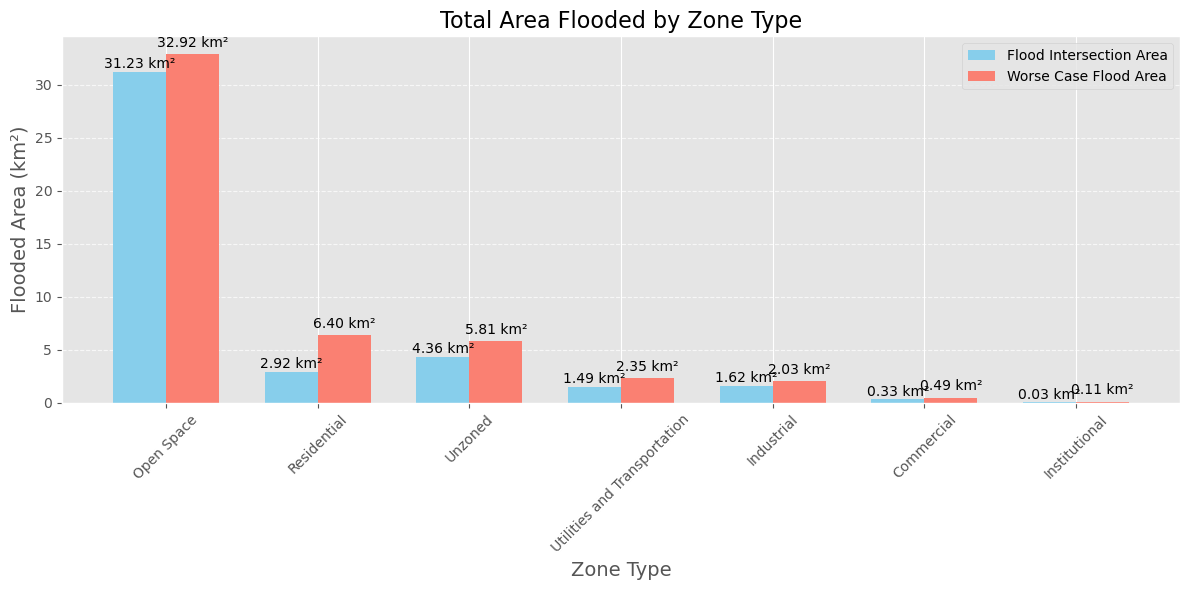

In [137]:
# Let's visualize these changes...

# Sort the data by flooded area (descending order)
aggregated_zones_sorted = aggregated_zones.sort_values(by='Worse case flood area', ascending=False)

# Number of bars (zones)
num_zones = len(aggregated_zones_sorted)

# Set the positions of the bars (side by side for each zone)
x = np.arange(num_zones)

# Width of each bar
bar_width = 0.35

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the two bars for each zone type
bars1 = plt.bar(x - bar_width / 2, aggregated_zones_sorted['flood_intersection_area'], 
                width=bar_width, label='Flood Intersection Area', color='skyblue')

bars2 = plt.bar(x + bar_width / 2, aggregated_zones_sorted['Worse case flood area'], 
                width=bar_width, label='Worse Case Flood Area', color='salmon')

# Add title and labels
plt.title('Total Area Flooded by Zone Type', fontsize=16)
plt.xlabel('Zone Type', fontsize=14)
plt.ylabel('Flooded Area (km²)', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(x, aggregated_zones_sorted['Zone_type'], rotation=45)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels above each bar
for i in range(num_zones):
    plt.text(x[i] - bar_width / 2, aggregated_zones_sorted['flood_intersection_area'].iloc[i] + 0.05, 
             f'{aggregated_zones_sorted["flood_intersection_area"].iloc[i]:.2f} km²', 
             ha='center', va='bottom', fontsize=10)

    plt.text(x[i] + bar_width / 2, aggregated_zones_sorted['Worse case flood area'].iloc[i] + 0.4, 
             f'{aggregated_zones_sorted["Worse case flood area"].iloc[i]:.2f} km²', 
             ha='center', va='bottom', fontsize=10)

# Add legend
plt.legend()

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

### Now we can consider where this is happening...